In [11]:
import os
import pandas as pd
from math import ceil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
import datetime


threshold = 1000

In [12]:
# Load Data
def load_raw(fn):
    datapath = os.path.join('../csse_covid_19_data/csse_covid_19_time_series/', fn)

    #datapath = '../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    
    raw = pd.read_csv(datapath)
    del raw['Lat']
    del raw['Long']
    raw = raw.replace('Mainland China','China')
    return raw

raw = load_raw('time_series_covid19_confirmed_global.csv')
raw_deaths = load_raw('time_series_covid19_deaths_global.csv')
raw


,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,29481,29640,30175,30451,30616,30967,31238,31517,31836,32022
1,NaN,Albania,0,0,0,0,0,0,0,0,...,2047,2114,2192,2269,2330,2402,2466,2535,2580,2662
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,12076,12248,12445,12685,12968,13273,13571,13907,14272,14657
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,855,855,855,855,855,855,855,855,855,855
4,NaN,Angola,0,0,0,0,0,0,0,0,...,189,197,212,212,259,267,276,284,291,315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Sao Tome and Principe,0,0,0,0,0,0,0,0,...,707,710,711,712,713,713,713,714,715,717
262,NaN,Yemen,0,0,0,0,0,0,0,0,...,992,1015,1076,1089,1103,1118,1128,1158,1190,1221
263,NaN,Comoros,0,0,0,0,0,0,0,0,...,265,265,272,272,272,272,272,303,303,303
264,NaN,Tajikistan,0,0,0,0,0,0,0,0,...,5567,5630,5691,5747,5799,5849,5900,5900,6005,6058


In [13]:
# Shift all the series
def shift(df, threshold=1000):
    maxDate = max(df.index)    
    for c in df.columns:
        for i,a in enumerate(df[c]):        
            if i==0 and a>threshold:
                df[c]=df[c].shift(4) # hack to push out china
                break
            if a>=threshold:
                df[c]=df[c].shift(-i)            
                break
    df=df.reset_index(drop=True)
    #del df['China']
    return df


In [14]:
%matplotlib inline
from math import pow


def plotdataframe(df, logy=False, legend=True):
    plt.rcParams["figure.figsize"] = [10, 10]
    fig, ax = plt.subplots()
    markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
    for c,m in zip(df,markers):
        df[c].plot(logy=logy, marker=m, fontsize=12,ax=ax, linewidth=2.5)
    
    font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)
    legend and ax.legend(prop=font)

    return ax

def plotdataframe_point(df, logy=False, legend=True, legend_loc='best', title=None):
    plt.rcParams["figure.figsize"] = [10, 10]
    fig, ax = plt.subplots()
    markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
    lines = []
    legendcols = []
    maxX = max([max([x for c in df for (x,y) in zip(df.index,df[c]) if y>0])])
    #print(maxX)
    for c,m in zip(df,markers):
        pts = list([x for (x,y) in zip(df.index,df[c]) if y>0])
        ys = list([x for x in df[c] if x>0])
        if len(pts)<=1:
            continue
        legendcols.append(c)
        df[c].plot(logy=logy, marker=m, fontsize=12,ax=ax, linewidth=1) #, color='#999999')
        
        offset = (10,0)
        #print([pts[0],pts[-1]],[ys[0],ys[-1]])
        #l,=ax.plot([pts[0],pts[-1]],[ys[0],ys[-1]], linewidth=2.5, marker=m)
        #lines.append(l)
        #growth = round((pow(ys[-1]/ys[0],1.0/(pts[-1]-pts[0]))-1)*100)
        growth = round((pow(ys[-1]/ys[-8],1.0/(pts[-1]-pts[-8]))-1)*100)
        
        alignment = 'left'
        if pts[-1]>0.9*maxX:
            offset = (0,5)
            alignment = 'center'
        ax.annotate('{} ({}%)'.format(c,growth), xy=(pts[-1],ys[-1]), xytext=offset, textcoords='offset points', ha=alignment, size=12)
    
    if logy:
        ax.get_yaxis().set_major_formatter(
            ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)
    legend and ax.legend(lines,legendcols,prop=font, loc=legend_loc)

    title and ax.set_title(title, size=14)
    return ax

def save_figure(maxDate, filename):
    savedir = os.path.join('data',maxDate.strftime('%Y%m%d'))
    if not os.path.isdir(savedir):
        os.makedirs(savedir)
    plt.savefig(os.path.join(savedir,filename))


In [16]:
df=raw.groupby('Country/Region').sum()
last_date = list(df.columns)[-1]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
    #del df['Cruise Ship']

threshold = 1000
del df['China']
columnsToSelect = list(set(list(sorted(df.columns, key=lambda c: max(df[c]), reverse=True))[:10]+['Canada','Australia','Czechia']))
#print(columns)
#df = df[[c for c in df.columns if df[c].max()>12000 or c in ['Canada','US', 'Australia','Czechia']]]
df=df[columnsToSelect]
maxDate = max(df.index)
df = shift(df)

ax=plotdataframe_point(df, logy=True, legend_loc='upper left', title='Countries time-shifted. (% is 7 days avg growth)')
ax.set_xlabel("Days since reaching {} cases".format(threshold), size=12)
ax.set_ylabel("Confirmed cases." , size=12)
ax.grid(axis='y')
ax.text(0.97, 0.09, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
save_figure(maxDate,'1_countryshift.png')
plt.close()


Removed:  ['Albania', 'Andorra', 'Antigua and Barbuda', 'Armenia', 'Austria', 'Bahamas', 'Bahrain', 'Barbados', 'Belarus', 'Belize', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brunei', 'Bulgaria', 'Burma', 'Cabo Verde', 'Central African Republic', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cyprus', 'Denmark', 'Diamond Princess', 'Djibouti', 'Dominica', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Fiji', 'Finland', 'Gabon', 'Gambia', 'Georgia', 'Grenada', 'Guinea-Bissau', 'Guyana', 'Holy See', 'Honduras', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Jamaica', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'MS Zaandam', 'Maldives', 'Malta', 'Mauritania', 'Mauritius', 'Moldova', 'Monaco', 'Mongolia', 'Montenegro', 'Namibia', 'New Zealand', 'Nicaragua', 'North Macedonia', 'Norway', 'Oman', 'Panama', 'Papua

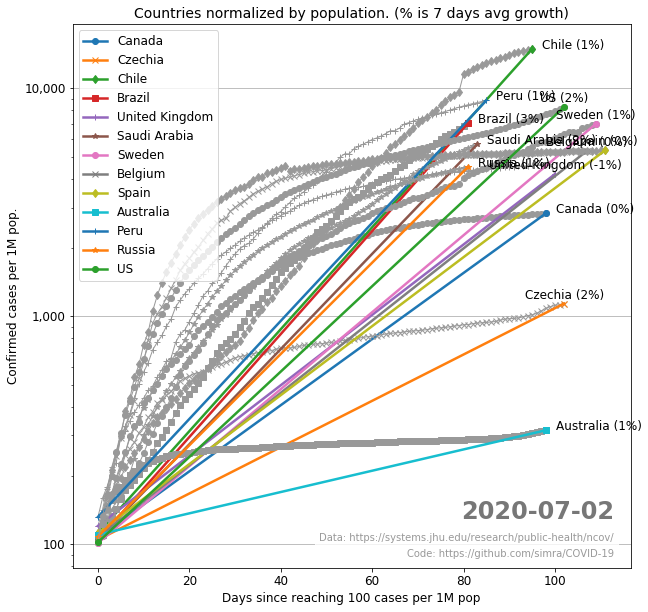

In [6]:
# Try normalizing by population
# https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv
wpp = pd.read_csv('../wpp/WPP2019_TotalPopulationBySex.csv')
wpp=wpp[(wpp['Time']==2020) & (wpp['Variant']=='Medium')]
wpp = dict(zip(wpp['Location'],wpp['PopTotal']))
wpp['Iran']=wpp['Iran (Islamic Republic of)']
wpp['US']=wpp['United States of America']
wpp['Korea, South']= wpp['Republic of Korea']
wpp['Russia'] = wpp['Russian Federation']

df=raw.groupby('Country/Region').sum()
last_date = list(df.columns)[-1]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
    #del df['Cruise Ship']

columnsRemoved = [c for c in df.columns if c not in wpp or wpp[c]<10000]
columnsFiltered = [c for c in df.columns if c in wpp and wpp[c]>=10000]
df = df[columnsFiltered]
print("Removed: ",columnsRemoved)

#df = df[[c for c in df.columns if df[c].max()>10000 or c in ['Canada','US', 'Australia', 'Czechia']]]
for c in df.columns:
    df[c] = df[c]*1000/wpp[c]
#df = df[[c for c in df.columns if df[c].max()>1000 or c in ['Canada','US', 'Australia', 'Czechia']]]
columnsToSelect = list(set(list(sorted(df.columns, key=lambda c: max(df[c]), reverse=True))[:10]+['Canada','US','Australia','Czechia']))
df=df[columnsToSelect]


#plotdataframe(df, logy=True)
maxDate = max(df.index)
threshold = 100
df= shift(df,threshold=threshold)

ax=plotdataframe_point(df, logy=True, legend_loc='upper left', title="Countries normalized by population. (% is 7 days avg growth)")
ax.set_xlabel("Days since reaching {} cases per 1M pop".format(threshold), size=12)
ax.set_ylabel("Confirmed cases per 1M pop." , size=12)
ax.grid(axis='y')
ax.text(0.97, 0.09, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
save_figure(maxDate,'2_countryshift_norm.png')

#wpp

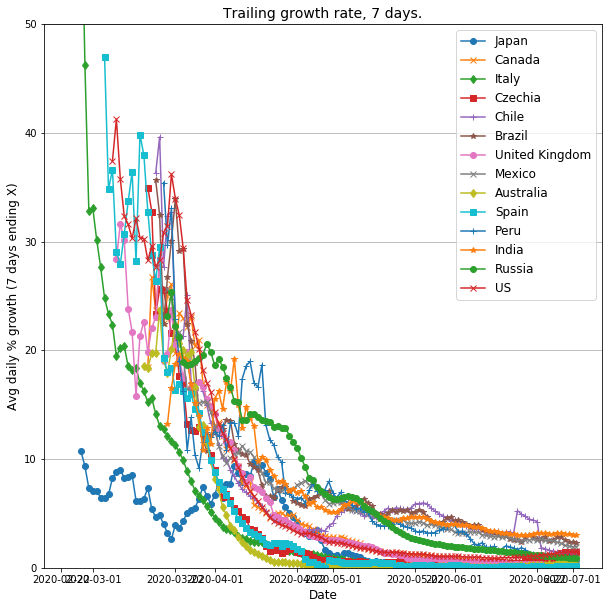

In [7]:
df=raw.groupby('Country/Region').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

#df = df[(df.index.isin(['Canada','Japan', 'Australia'])) | (df[last_date]>20000)]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
#del df['Cruise Ship']

columnsToSelect = list(set(list(sorted(df.columns, key=lambda c: max(df[c]), reverse=True))[:10]+['Canada','Australia','Japan','Czechia']))
df = df[columnsToSelect]

maxDate=max(df.index)

plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
for c,m in zip(df.columns,markers):
    growth[c] = [(pow(df[c][i]/max(1.0,df[c][i-6]),1.0/7)-1)*100 if df[c][i]>200 else float('nan') for i in range(20,len(df[c]))]
    #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
    #if c=='France':
    #    print(list(df[c]))
    ax.plot(df.index[20:], growth[c], marker=m)

    
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)


ax.grid(axis='y') 
#ax.yaxis.set_label_position("right")
ax.set_ylim([0,50])
ax.set_xlabel('Date', size=12)
ax.set_ylabel('Avg daily % growth (7 days ending X)', size=12)
ax.set_title('Trailing growth rate, 7 days.', size=14)
ax.legend(df.columns, prop=font)    
#plt.ylim((0,100))
save_figure(maxDate,'3_growth.png')

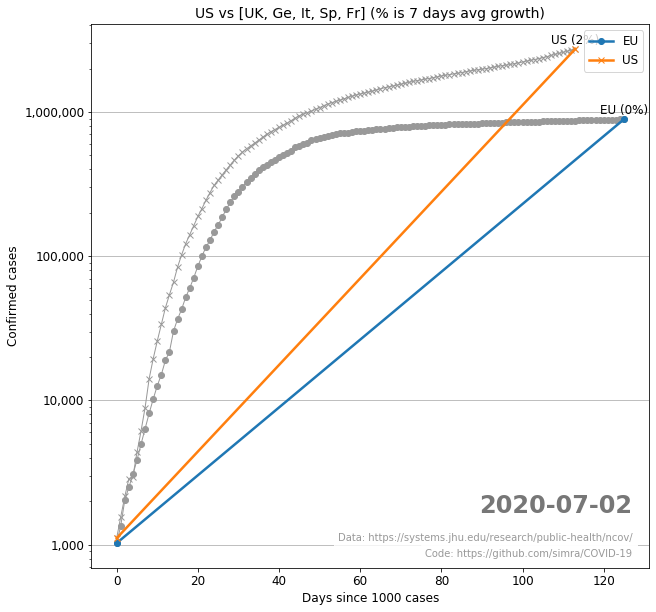

In [8]:
df=raw.groupby('Country/Region').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

#df = df[(df.index.isin(['Canada','Japan'])) | (df[last_date]>4000)]
df = df[df.index.isin(['US','France','Germany','Italy','Spain', 'UK'])]
df = df.groupby(df.index=='US').sum()
df.index = ['US' if c else 'EU' for c in df.index]
df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
#del df['Cruise Ship']
maxDate = max(df.index)
threshold = 1000
df=shift(df,threshold=threshold)
ax=plotdataframe_point(df, logy=True)

ax.set_xlabel('Days since {} cases'.format(threshold), size=12)
ax.set_ylabel('Confirmed cases', size=12)
ax.grid(axis='y')
ax.set_title('US vs [UK, Ge, It, Sp, Fr] (% is 7 days avg growth)', size=14)
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

save_figure(maxDate, '6_euus.png')

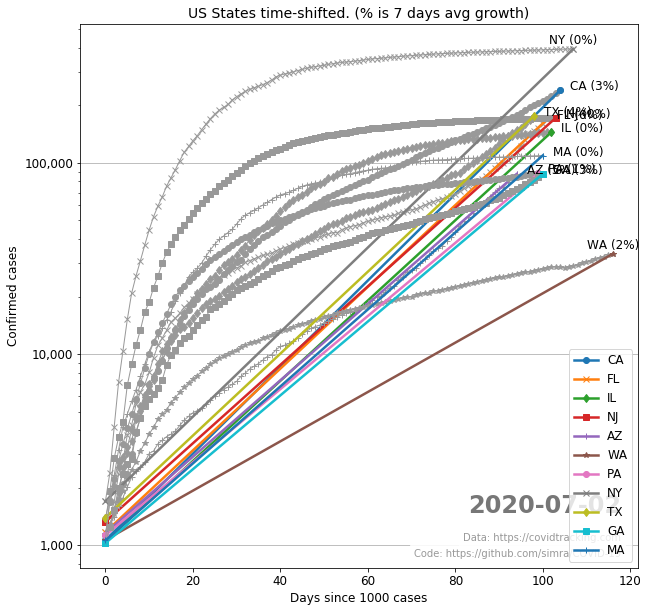

In [9]:
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
df = covidtracking.pivot(index='date',columns='state', values='positive')
df = df.fillna(0)
columnsToSelect = list(set(list(sorted(df.columns, key=lambda c: max(df[c]), reverse=True))[:10]+['WA']))
#df = df[[c for c in df.columns if df[c].max()>5000 or c=='WA']]
df = df[columnsToSelect]

shift_threshold = 1000
df = shift(df, threshold=shift_threshold)

ax=plotdataframe_point(df, logy=True, title='US States time-shifted. (% is 7 days avg growth)')


ax.set_xlabel('Days since {} cases'.format(shift_threshold), size=12)
ax.set_ylabel('Confirmed cases', size=12)
ax.grid(axis='y')
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800, bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.05, 'Data: https://covidtracking.com', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

save_figure(maxDate,'9_usstates.png')


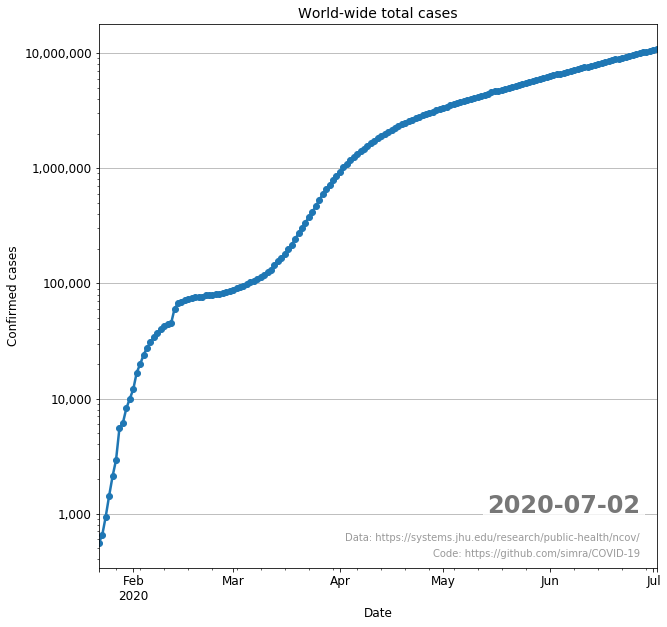

In [10]:
df=raw.groupby(lambda x: True).sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

#df = df[(df.index.isin(['Canada','Japan'])) | (df[last_date]>4000)]
#df = df[df.index.isin(['US','France','Germany','Italy','Spain'])]
#df = df.groupby(df.index=='US').sum()
df.index = ['World']
df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
maxDate = max(df.index)
#del df['Cruise Ship']
#df=shift(df)
df
ax=plotdataframe(df, logy=True, legend=False)
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel('Date', size=12)
ax.set_title('World-wide total cases', size=14)
ax.grid(axis='y')
ax.set_ylabel('Confirmed cases', size=12)
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800, bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

save_figure(maxDate,'7_world.png')

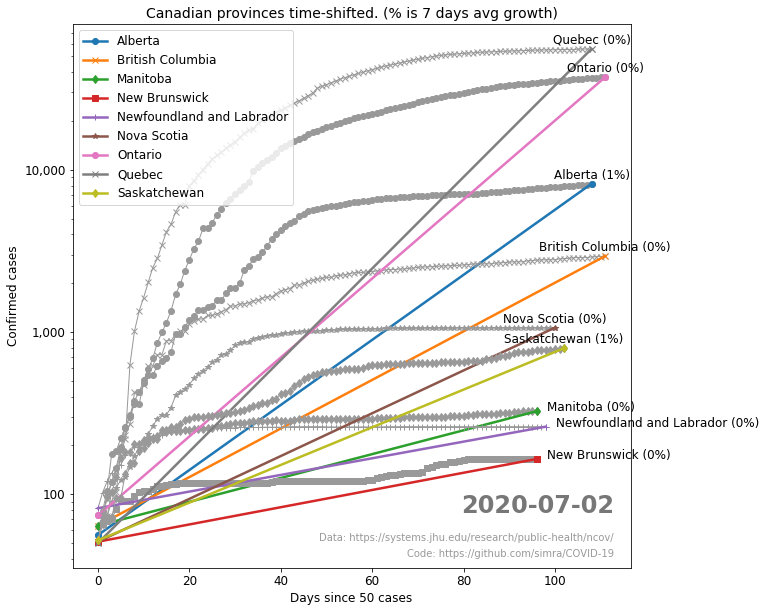

In [11]:
df = raw[raw['Country/Region']=='Canada']
df=df.groupby('Province/State').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]
threshold=50
df = df[df[last_date]>threshold]
#df = df[df.index.isin(['US','France','Germany','Italy','Spain'])]
#df = df.groupby(df.index=='US').sum()
#df.index = ['World']

df['Province/State']=df.index
df=df.melt(id_vars='Province/State',var_name='date', value_name='Confirmed').pivot(index='date',columns='Province/State')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
for c in ['Recovered', 'Diamond Princess', 'Grand Princess']:
    if c in df:
        del df[c] 

maxDate = max(df.index)
df=shift(df,threshold)
df
ax=plotdataframe_point(df, logy=True, legend_loc='upper left', title='Canadian provinces time-shifted. (% is 7 days avg growth)')
ax.set_xlabel('Days since {} cases'.format(threshold), size=12)
ax.set_ylabel('Confirmed cases', size=12)
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

save_figure(maxDate, '8_canada.png')

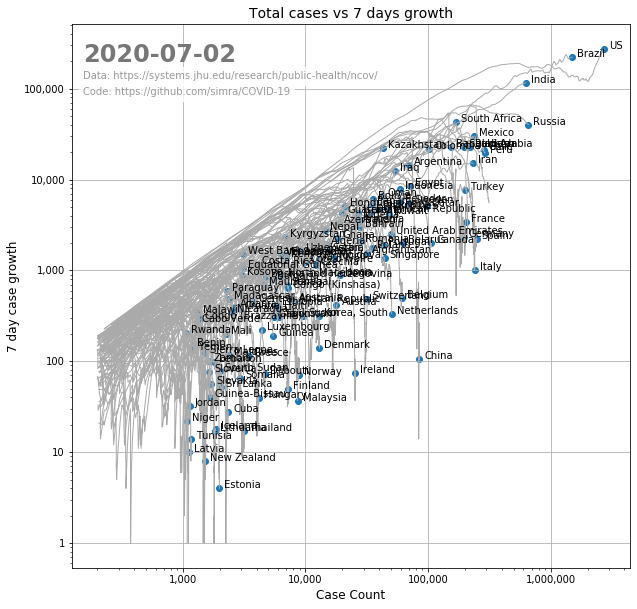

In [12]:
df=raw.groupby('Country/Region').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

df = df[(df.index.isin(['Canada','Japan', 'Australia'])) | (df[last_date]>1000)]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
#del df['Cruise Ship']
maxDate=max(df.index)

plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
points = []
markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
start = 20
for c,m in zip(df.columns,markers):
    #growth[c] = [(pow(df[c][i]/max(1.0,df[c][i-6]),1.0/7)-1)*100 if df[c][i]>200 else float('nan') for i in range(20,len(df[c]))]
    growth[c] = [df[c][i]-df[c][i-6] if (df[c][i]>200 and df[c][i]>df[c][i-6]) else float('nan') for i in range(start,len(df[c]))]
    #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
    ax.plot(df[c][start:], growth[c], linewidth=1,color='#aaaaaa')
    points.append([df[c][-1],growth[c][-1],c])

ax.scatter([p[0] for p in points],[p[1] for p in points])   
for (x,y,txt) in points:
    ax.annotate(txt,(x,y), xytext=(5,0), textcoords='offset points')
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)


ax.grid()
ax.set_xscale('log')
ax.set_yscale('log')
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax.yaxis.set_label_position("right")
#ax.set_ylim([0,50])
ax.set_xlabel('Case Count', size=12)
ax.set_ylabel('7 day case growth', size=12)
ax.set_title('Total cases vs 7 days growth', size=14)
#ax.legend(df.columns, prop=font)    
#plt.ylim((0,100))
ax.text(0.02, 0.93, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='left', weight=800)
ax.text(0.02, 0.90, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.02, 0.87, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
save_figure(maxDate,'10_countvsgrowth.png')

[[2.30103    1.        ]
 [5.94542771 1.        ]] [3.89496284e+01 2.03953910e+05]


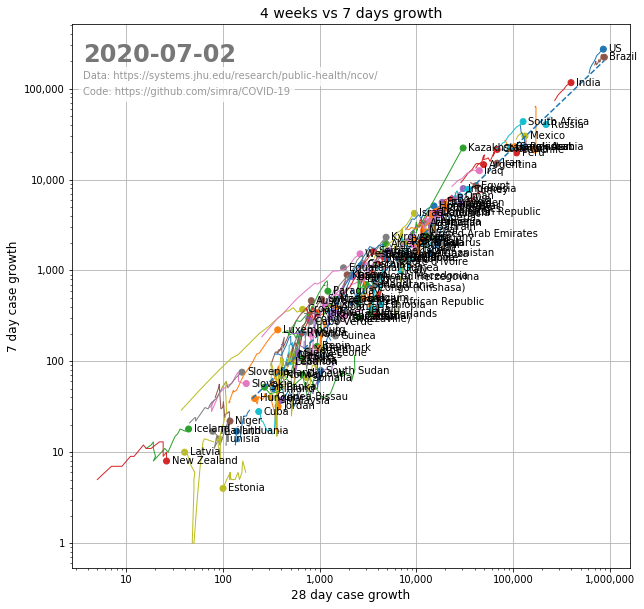

In [13]:
df=raw.groupby('Country/Region').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

df = df[(df.index.isin(['Canada','Japan', 'Australia'])) | (df[last_date]>1000)]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
#del df['Cruise Ship']
maxDate=max(df.index)

plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
growth_l = {}
points = []
markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colorsToUse=colors*ceil(len(df.columns)/len(colors))
long_window= 4*7
start = long_window
for c,m,col in zip(df.columns,markers,colorsToUse):
    #growth[c] = [(pow(df[c][i]/max(1.0,df[c][i-6]),1.0/7)-1)*100 if df[c][i]>200 else float('nan') for i in range(20,len(df[c]))]
    growth[c] = [df[c][i]-df[c][i-6] if (df[c][i]>200 and df[c][i]>df[c][i-6]) else float('nan') for i in range(start,len(df[c]))]
    growth_l[c] = [df[c][i]-df[c][i-long_window] if (df[c][i]>200 and df[c][i]>df[c][i-long_window]) else float('nan') for i in range(start,len(df[c]))]
    #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
    ax.plot(growth_l[c][-14:], growth[c][-14:], linewidth=1,color=col)
    points.append([growth_l[c][-1],growth[c][-1],c])

ax.scatter([p[0] for p in points],[p[1] for p in points],color=colorsToUse[:len(points)])   
for (x,y,txt) in points:
    ax.annotate(txt,(x,y), xytext=(5,0), va='center', textcoords='offset points')
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)



from math import log10 as log
x = [log(growth_l[c][-1]) if growth_l[c][-1]>0 else 0 for c in growth]
y = [log(growth[c][-1]) if growth[c][-1]>0 else 0 for c in growth]
model = np.polyfit(x,y,1)
model
model_x = np.array([[log(200),1],[max(x),1]])
model_y = np.power(10,model_x.dot(model))
print(model_x,model_y)
ax.plot(np.power(10,model_x[:,0]), model_y, linestyle='--')

ax.grid()
ax.set_xscale('log')
ax.set_yscale('log')
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax.yaxis.set_label_position("right")
#ax.set_ylim([0,50])
ax.set_xlabel('28 day case growth', size=12)
ax.set_ylabel('7 day case growth', size=12)
ax.set_title('4 weeks vs 7 days growth', size=14)
#ax.legend(df.columns, prop=font)    
#plt.ylim((0,100))
ax.text(0.02, 0.93, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='left', weight=800)
ax.text(0.02, 0.90, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.02, 0.87, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
save_figure(maxDate,'10_b_countvsgrowth_8week.png')

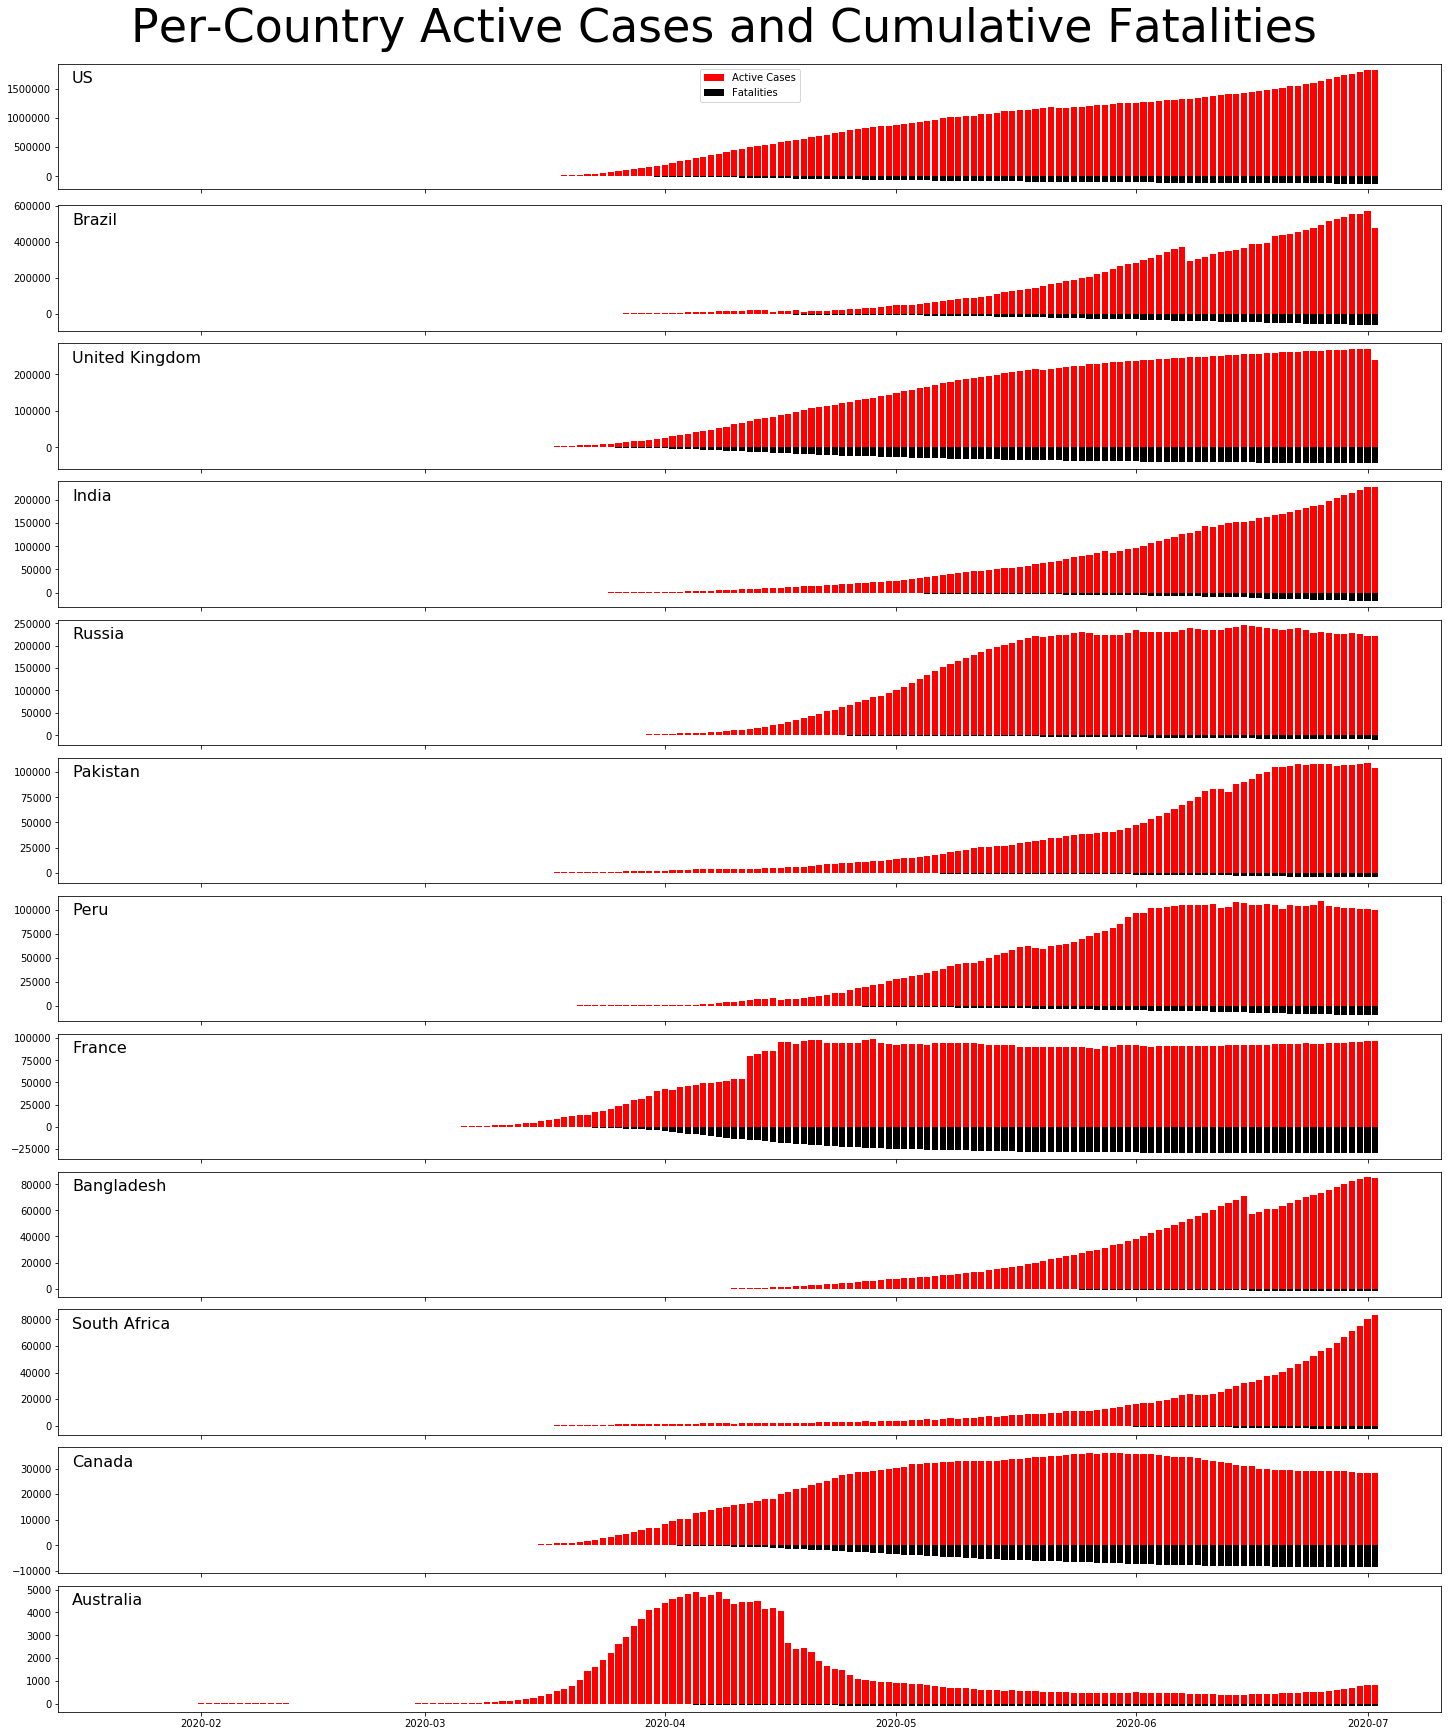

In [14]:


def prepData(datapath):
    raw = pd.read_csv(datapath)
    del raw['Lat']
    del raw['Long']
    raw= raw.replace('Mainland China','China')
    df=raw.groupby('Country/Region').sum()
    # 03/14: temporarily drop the last column
    #del df[df.columns[-1]]
    last_date = list(df.columns)[-1]

    #df = df[(df.index.isin(['Canada','Japan'])) | (df[last_date]>100)]

    df['Country/Region']=df.index
    df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
    df['date']=pd.to_datetime(df.index)

    df.index.name = None
    df=df.sort_values(by=['date'])
    df.set_index('date', inplace=True)
    df.columns = [c[1] for c in df.columns]
    return df

deaths = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
confirmed = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')


def plotBars(countries):
    plt.rcParams["figure.figsize"] = [20, 2*len(countries)]
    fig, axs = plt.subplots(len(countries),1, sharex=True,constrained_layout=True)
    fig.suptitle('Per-Country Active Cases and Cumulative Fatalities',size=46)
    for (i,(country,ax)) in enumerate(zip(countries,axs)):
        active = []
        for (c,r,d) in zip(confirmed[country], recovered[country], deaths[country]):
            active.append(c-r-d) 
        #if country=='Canada':
        #print(active,confirmed[country])
        ax.bar(confirmed.index,active, color='red')
        rec = []
        for (r,d) in zip(recovered[country],deaths[country]):
            rec.append(r+d)        
        #ax.bar(recovered.index,rec, color='green')
        ax.bar(deaths.index, deaths[country]*(-1), color='black')
        #ax.set_yscale('log')
        ax.text(0.01,0.85,country, transform=ax.transAxes, ha='left', size=16) 
        
        if i==0:
            ax.legend(['Active Cases','Fatalities'], loc='upper center')

countries = sorted(confirmed.columns, key=lambda x: confirmed[x][-1]-recovered[x][-1]-deaths[x][-1], reverse=True)[:10]
for c in ['Canada','Australia']:
    if c not in countries:
        countries+=[c]
#plotBars(['China','Canada','US','Italy','Singapore','Korea, South','Japan','Germany','France','Australia','United Kingdom','Spain'])
plotBars(countries)

maxDate = confirmed.index[-1]
#print(maxDate)
save_figure(maxDate,'5_barplots.png')

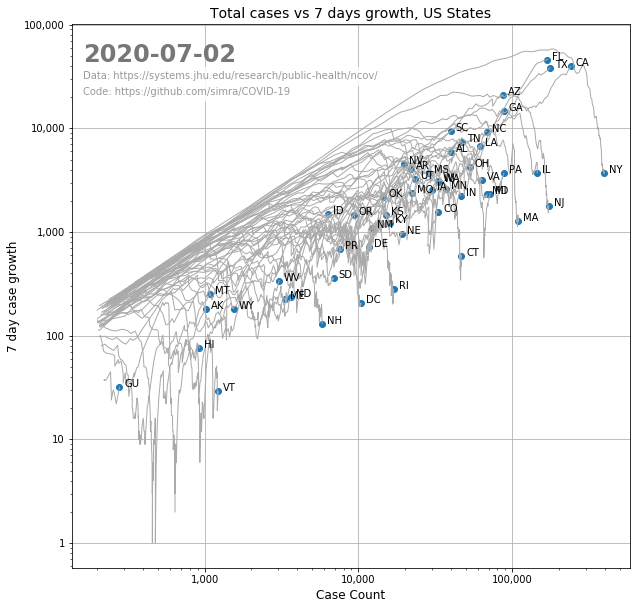

In [15]:
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
df = covidtracking.pivot(index='date',columns='state', values='positive')
#df = df[[c for c in df.columns if df[c].max()>1000]]

maxDate=max(df.index)
plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
points = []

markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
growth = {}
start = 7
#print(list(zip(df.columns,markers))[42])
#print(df['PR'])
for c,m in list(zip(df.columns,markers)):
    #growth[c] = [(pow(df[c][i]/max(1.0,df[c][i-6]),1.0/7)-1)*100 if df[c][i]>200 else float('nan') for i in range(20,len(df[c]))]
    growth[c] = [df[c][i]-df[c][i-6] if (df[c][i]>200 and df[c][i]>df[c][i-6]) else float('nan') for i in range(start,len(df[c]))]
    #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
    #print(max(df[c]),max(growth[c]))
    ax.plot(df[c][start:], growth[c], linewidth=1,color='#aaaaaa')
    points.append([df[c][-1],growth[c][-1],c])
    

ax.scatter([p[0] for p in points],[p[1] for p in points])   
for (x,y,txt) in points:
    ax.annotate(txt,(x,y), xytext=(5,0), textcoords='offset points')
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)


ax.grid() 
ax.set_xscale('log')
ax.set_yscale('log')
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax.yaxis.set_label_position("right")
#ax.set_ylim([0,50])
ax.set_xlabel('Case Count', size=12)
ax.set_ylabel('7 day case growth', size=12)
ax.set_title('Total cases vs 7 days growth, US States', size=14)
#ax.legend(df.columns, prop=font)    
#plt.ylim((0,100))
ax.text(0.02, 0.93, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='left', weight=800)
ax.text(0.02, 0.90, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.02, 0.87, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))


save_figure(maxDate,'11_usstatesgrowth.png')

[[2.30103    1.        ]
 [5.47712125 1.        ]] [   81.25701696 74582.14756194]


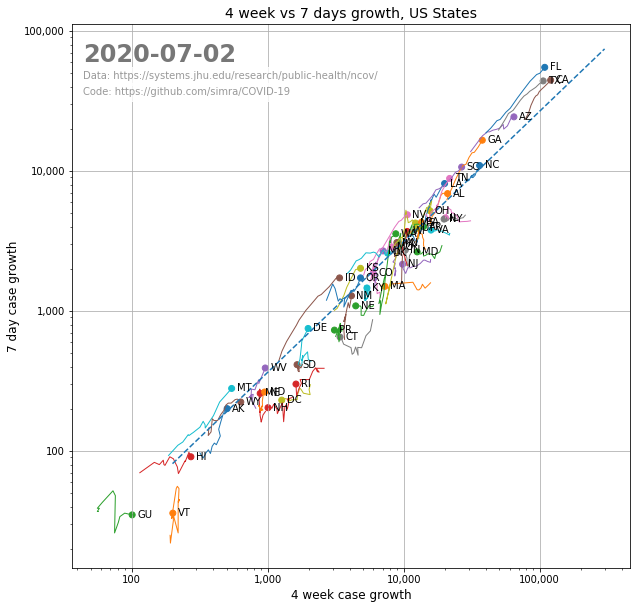

In [16]:
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
df = covidtracking.pivot(index='date',columns='state', values='positive')
#df = df[[c for c in df.columns if df[c].max()>1000]]

maxDate=max(df.index)
plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
points = []

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
growth = {}
growth_l = {}
window_long = 4*7
start = window_long
colorsToUse=colors*ceil(len(df.columns)/len(colors))
#print(colorsToUse)                        
for c,m,col in zip(df.columns,markers,colorsToUse):
    #growth[c] = [(pow(df[c][i]/max(1.0,df[c][i-6]),1.0/7)-1)*100 if df[c][i]>200 else float('nan') for i in range(20,len(df[c]))]
    growth[c] = [df[c][i]-df[c][i-7] if (df[c][i]>200 and df[c][i]>df[c][i-7]) else float('nan') for i in range(start,len(df[c]))]
    growth_l[c] = [df[c][i]-df[c][i-window_long] if (df[c][i]>200 and df[c][i]>df[c][i-window_long])  else float('nan') for i in range(start,len(df[c]))]    
    #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
    #print(growth_l[c],growth[c])
    ax.plot(growth_l[c][-14:], growth[c][-14:], linewidth=1,color=col)
    points.append([growth_l[c][-1],growth[c][-1],c])

ax.scatter([p[0] for p in points],[p[1] for p in points],color=colorsToUse[:len(points)])   
for (x,y,txt) in points:
    ax.annotate(txt,(x,y), xytext=(5,0), va='center', textcoords='offset points')
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)


ax.grid() 
ax.set_xscale('log')
ax.set_yscale('log')
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax.yaxis.set_label_position("right")
#ax.set_ylim([0,50])
ax.set_xlabel('4 week case growth', size=12)
ax.set_ylabel('7 day case growth', size=12)
ax.set_title('4 week vs 7 days growth, US States', size=14)
#ax.legend(df.columns, prop=font)    
#plt.ylim((0,100))
ax.text(0.02, 0.93, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='left', weight=800)
ax.text(0.02, 0.90, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.02, 0.87, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

from math import log10 as log
x = [log(growth_l[c][-1]) if growth_l[c][-1]>0 else 0 for c in growth]
y = [log(growth[c][-1]) if growth[c][-1]>0 else 0 for c in growth]
model = np.polyfit(x,y,1)
model
model_x = np.array([[log(200),1],[log(300000),1]])
model_y = np.power(10,model_x.dot(model))
print(model_x,model_y)
ax.plot(np.power(10,model_x[:,0]), model_y, linestyle='--')

save_figure(maxDate,'11_b_usstatesgrowth.png')

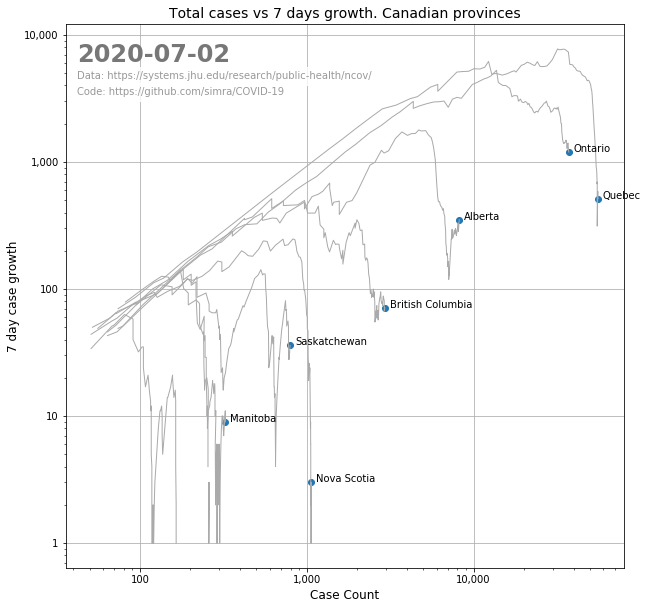

In [17]:
df = raw[raw['Country/Region']=='Canada']
df=df.groupby('Province/State').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]
threshold=50
df = df[df[last_date]>threshold]
#df = df[df.index.isin(['US','France','Germany','Italy','Spain'])]
#df = df.groupby(df.index=='US').sum()
#df.index = ['World']

df['Province/State']=df.index
df=df.melt(id_vars='Province/State',var_name='date', value_name='Confirmed').pivot(index='date',columns='Province/State')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
for c in ['Recovered', 'Diamond Princess', 'Grand Princess']:
    if c in df:
        del df[c] 

maxDate = max(df.index)

plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
points = []

markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
growth = {}
start = 7
for c,m in zip(df.columns,markers):
    #growth[c] = [(pow(df[c][i]/max(1.0,df[c][i-6]),1.0/7)-1)*100 if df[c][i]>200 else float('nan') for i in range(20,len(df[c]))]
    growth[c] = [df[c][i]-df[c][i-7] if (df[c][i]>threshold and df[c][i]>df[c][i-7]) else float('nan') for i in range(start,len(df[c]))]
    #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
    ax.plot(df[c][start:], growth[c], linewidth=1,color='#aaaaaa')
    points.append([df[c][-1],growth[c][-1],c])

ax.scatter([p[0] for p in points],[p[1] for p in points])   
for (x,y,txt) in points:
    ax.annotate(txt,(x,y), xytext=(5,0), textcoords='offset points')
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)


ax.grid() 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Total cases vs 7 days growth. Canadian provinces', size=14)
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax.yaxis.set_label_position("right")
#ax.set_ylim([0,50])
ax.set_xlabel('Case Count', size=12)
ax.set_ylabel('7 day case growth', size=12)
#ax.legend(df.columns, prop=font)    
#plt.ylim((0,100))
ax.text(0.02, 0.93, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='left', weight=800)
ax.text(0.02, 0.90, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.02, 0.87, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))


save_figure(maxDate,'12_canadagrowth.png')


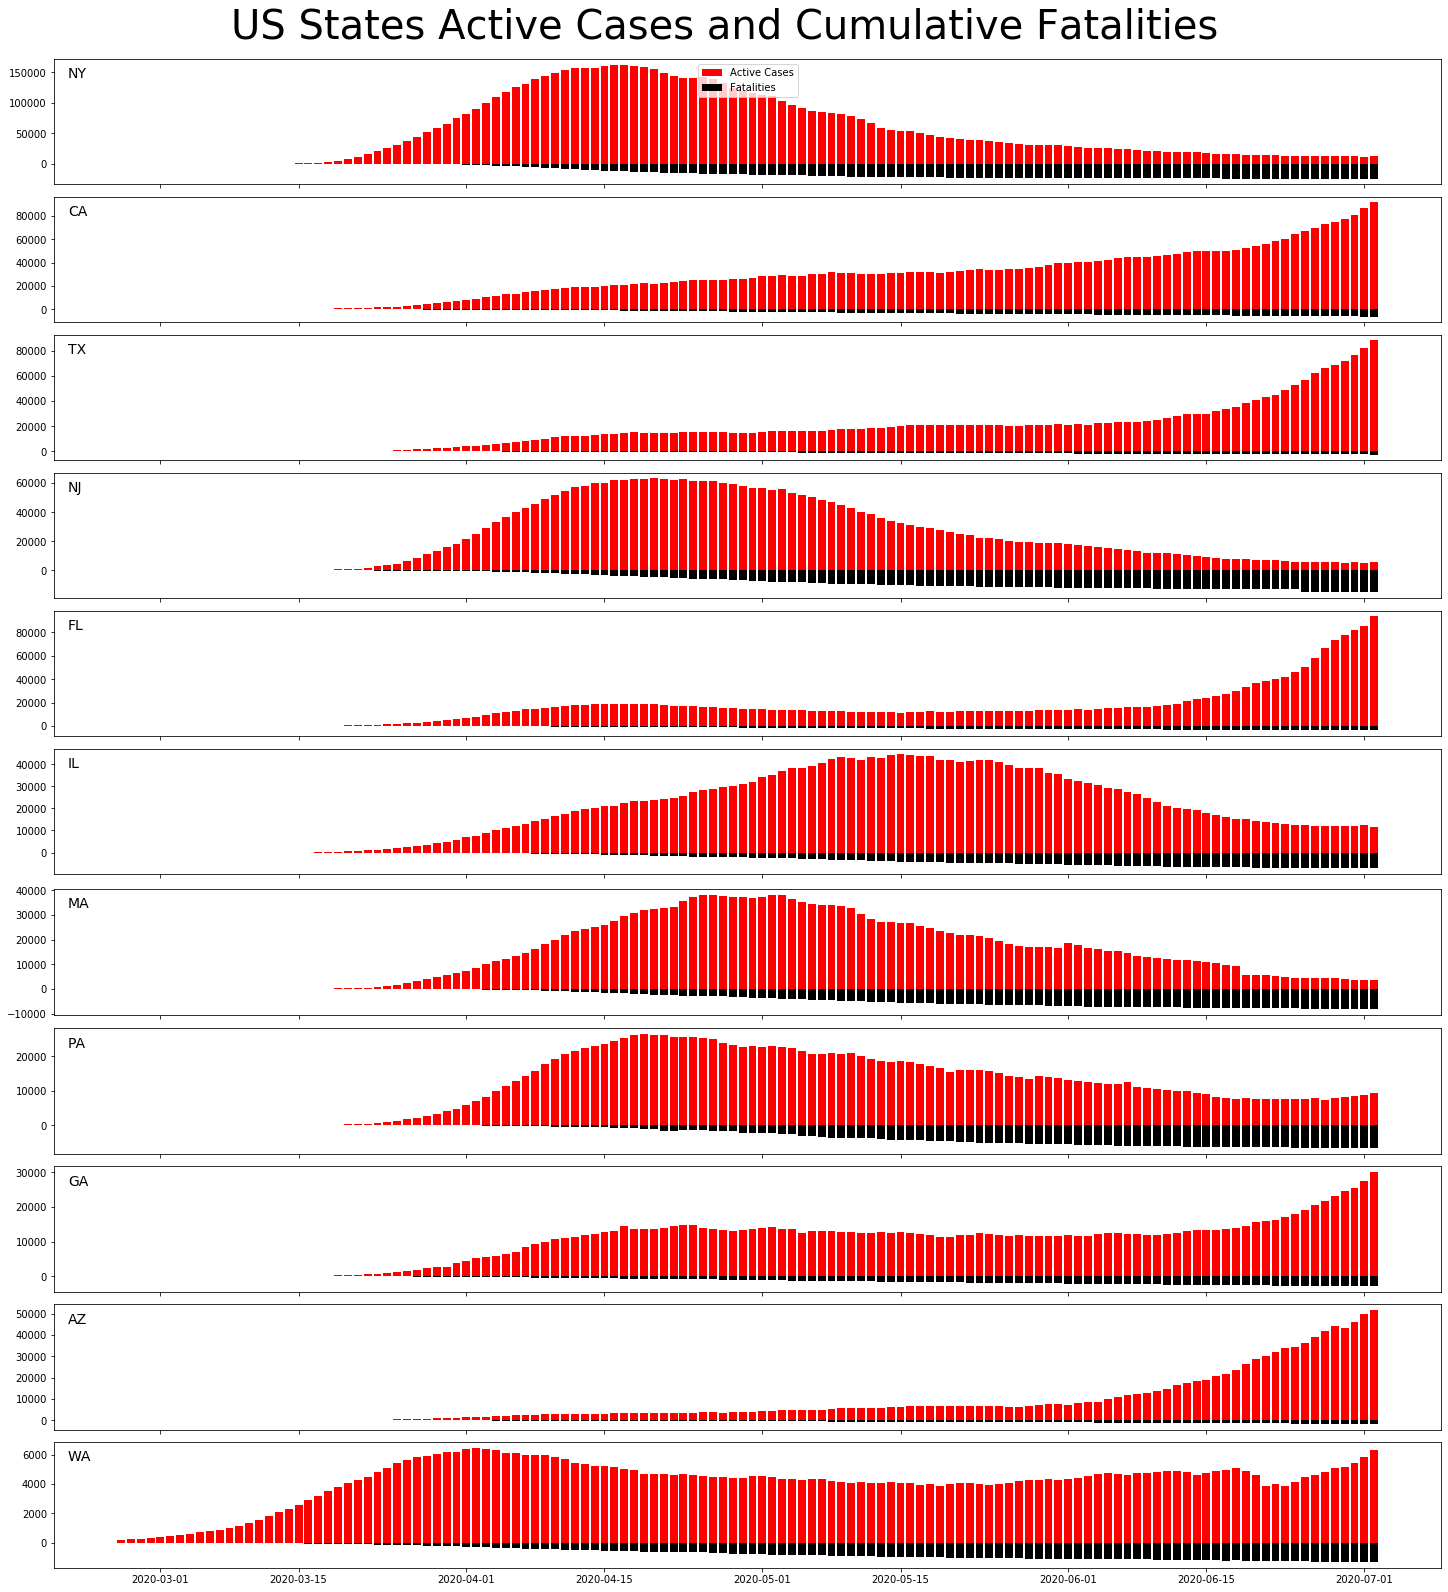

In [18]:
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
confirmed = covidtracking.pivot(index='date',columns='state', values='positive')
deaths = covidtracking.pivot(index='date',columns='state', values='death')
offset = 18

#df = df[[c for c in df.columns if df[c].max()>1000]]

maxDate=max(df.index)


def plotBars(countries):
    plt.rcParams["figure.figsize"] = [20, 2*len(countries)]
    fig, axs = plt.subplots(len(countries),1, sharex=True,constrained_layout=True)
    for (i,(country,ax)) in enumerate(zip(countries,axs)):
        recovered = [0 if j-offset<0 else max(0,confirmed[country][j-offset]-deaths[country][j]) for j in range(0,len(confirmed[country]))]
        active = []
        for (c,r,d) in zip(confirmed[country], recovered, deaths[country]):
            active.append(c-r-d)
        ax.bar(confirmed.index,active, color='red')
        #ax.bar(confirmed.index,recovered, color='red')
        rec = []
        #for (r,d) in zip(recovered,deaths[country]):
        #    rec.append(r+d)
        #ax.bar(recovered.index,rec, color='green')
        ax.bar(deaths.index, deaths[country]*(-1), color='black')
        #ax.set_yscale('log')
        ax.text(0.01,0.85,country, transform=ax.transAxes, ha='left', size=14)
        fig.suptitle('US States Active Cases and Cumulative Fatalities',size=40)
        if i==0:
            ax.legend(['Active Cases','Fatalities'], loc='upper center')

statesToPlot = list(sorted(confirmed.columns, key=lambda c: max(confirmed[c].fillna(0)), reverse=True)[:10])
if 'WA' not in statesToPlot:
    statesToPlot += ['WA']
#plotBars(['WA','NY','CA','NJ','MA','LA','FL'])
plotBars(statesToPlot)

maxDate = confirmed.index[-1]
#print(maxDate)
save_figure(maxDate,'16_usbarplots.png')

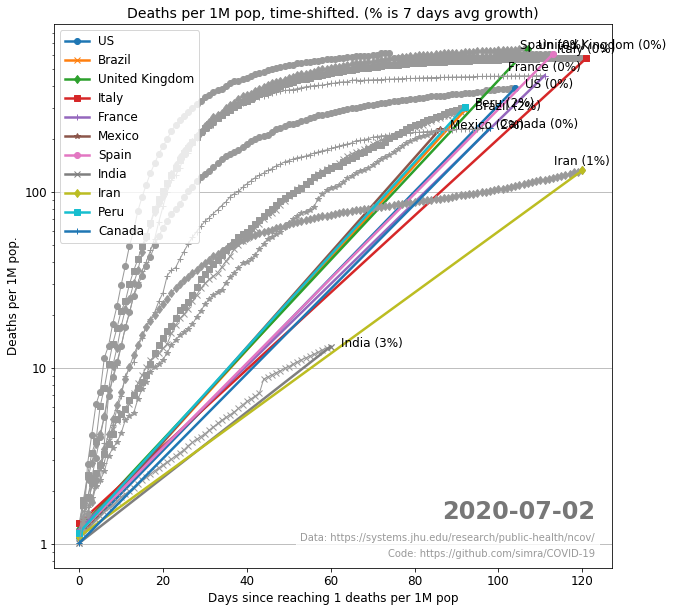

In [19]:
# Try normalizing by population
# https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv
wpp = pd.read_csv('../wpp/WPP2019_TotalPopulationBySex.csv')
wpp=wpp[(wpp['Time']==2020) & (wpp['Variant']=='Medium')]
wpp = dict(zip(wpp['Location'],wpp['PopTotal']))
wpp['Iran']=wpp['Iran (Islamic Republic of)']
wpp['US']=wpp['United States of America']
wpp['Korea, South']= wpp['Republic of Korea']
wpp['Russia'] = wpp['Russian Federation']
wpp['Bolivia'] = wpp['Bolivia (Plurinational State of)']

df=raw_deaths.groupby('Country/Region').sum()
last_date = list(df.columns)[-1]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
    #del df['Cruise Ship']

    
columns = list(sorted(df.columns, key=lambda x: df[x][-1], reverse=True))[:10]
for c in ['Canada','US']:
    if c not in columns:
        columns.append(c)
    
df = df[columns] #, 'Australia', 'Czechia'
for c in df.columns:
    df[c] = df[c]*1000/wpp[c]
#df = df[[c for c in df.columns if df[c].max()>10 or c in ['Canada','US']]] #, 'Australia', 'Czechia'

#plotdataframe(df, logy=True)
maxDate = max(df.index)
threshold = 1
df= shift(df,threshold=threshold)

ax=plotdataframe_point(df, logy=True, legend_loc='upper left', title='Deaths per 1M pop, time-shifted. (% is 7 days avg growth)')
ax.set_xlabel("Days since reaching {} deaths per 1M pop".format(threshold), size=12)
ax.set_ylabel("Deaths per 1M pop." , size=12)
ax.grid(axis='y')
ax.text(0.97, 0.09, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
save_figure(maxDate,'14_countryshift_norm-deaths.png')

#wpp

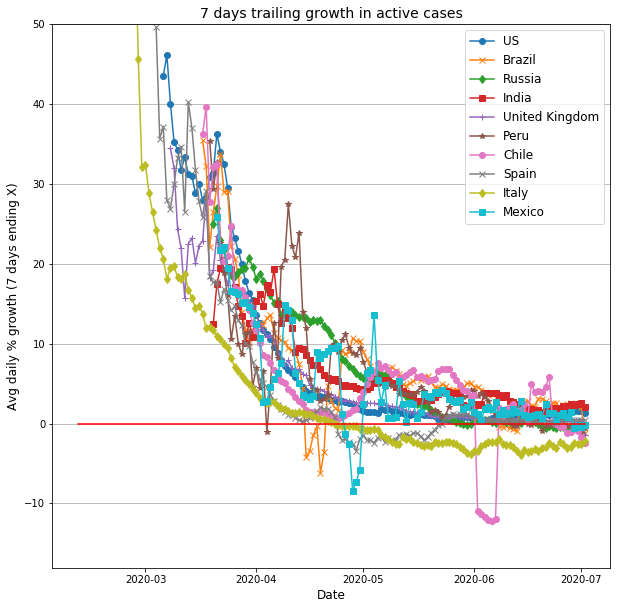

In [20]:
deaths = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
confirmed = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

columnsToSelect = sorted(confirmed.columns, key=lambda c: max(confirmed[c]), reverse=True)[:10]
#confirmed = confirmed[[c for c in confirmed.columns if max(confirmed[c])>10000]]
confirmed = confirmed[columnsToSelect]


def active(c):
    start = offset
    active = []
    for i in range(0,len(confirmed[c])):
        val = confirmed[c][i]-recovered[c][i]-deaths[c][i]
        if val<0: 
            print(c,confirmed[c][i], recovered[c][i], deaths[c][i])
        active.append(confirmed[c][i]-recovered[c][i]-deaths[c][i])        
    return active#del df['Cruise Ship']

maxDate=max(confirmed.index)

plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
markers = [item for sublist in ['oxds+*']*ceil(len(confirmed.columns)/5) for item in sublist]    
for c,m in zip(confirmed.columns,markers):  
    active_cases = active(c)
    growth[c] = [(pow(active_cases[i]/max(1.0,active_cases[i-6]),1.0/7)-1)*100 if active_cases[i]>200 else float('nan') for i in range(20,len(confirmed[c]))]
    #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
    ax.plot(confirmed.index[20:], growth[c], marker=m)

ax.plot(confirmed.index[20:], [0]*len(confirmed.index[20:]),color='#ff0000')
    
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)

ax.set_title('7 days trailing growth in active cases', size=14)
ax.grid(axis='y') 
#ax.yaxis.set_label_position("right")
lims=ax.get_ylim()
ax.set_ylim([lims[0],50])
ax.set_xlabel('Date', size=12)
ax.set_ylabel('Avg daily % growth (7 days ending X)', size=12)
ax.legend(confirmed.columns, prop=font)    
#plt.ylim((0,100))
save_figure(maxDate,'14_growthvsactive.png')

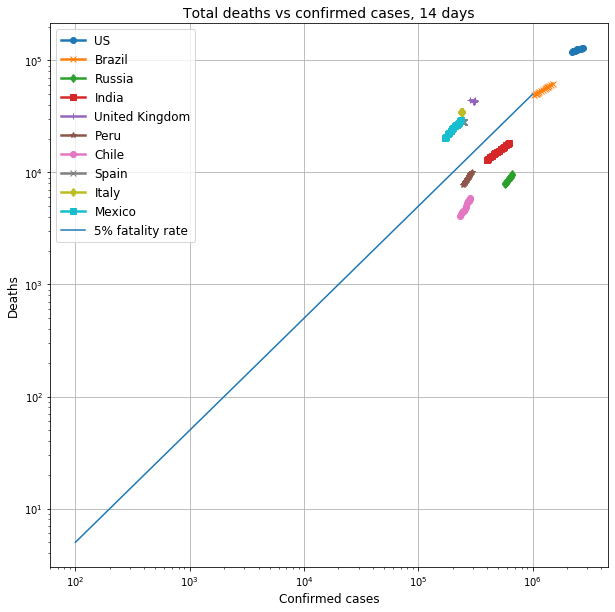

In [21]:
deaths = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
confirmed = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

columnsToSelect = sorted(confirmed.columns, key=lambda c: max(confirmed[c]), reverse=True)[:10]
#confirmed = confirmed[[c for c in confirmed.columns if max(confirmed[c])>10000]]
confirmed = confirmed[columnsToSelect]
deaths = deaths[[c for c in confirmed.columns]]

maxDate=max(confirmed.index)

plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
markers = [item for sublist in ['oxds+*']*ceil(len(confirmed.columns)/5) for item in sublist]    
for c,m in zip(confirmed.columns,markers):  
    ax.plot(confirmed[c][-14:],deaths[c][-14:], marker=m, linewidth=2.5)

ax.plot([100,1e6],[5,5e4])
    
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)


ax.grid() 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Confirmed cases', size=12)
ax.set_ylabel('Deaths', size=12)
ax.set_title('Total deaths vs confirmed cases, 14 days', size=14)
ax.legend(list(confirmed.columns)+['5% fatality rate'], prop=font)    
save_figure(maxDate,'15_deathsvsconfirmed.png')

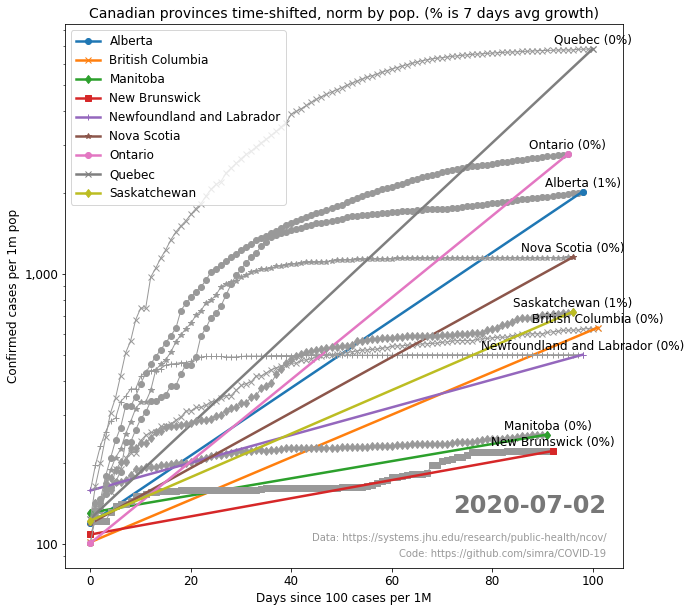

In [22]:
# 2016 census
canadapop = {
 'Ontario': 13448494,
 'Quebec': 8164361,
 'British Columbia': 4648055,
 'Alberta': 4067175,
 'Manitoba': 1278365,
 'Saskatchewan': 1098352,
 'Nova Scotia': 923598,
 'New Brunswick': 747101,
 'Newfoundland and Labrador': 519716,
 'Prince Edward Island': 142907,
 'Northwest Territories': 41786,
 'Nunavut': 35944,
 'Yukon': 35874

}

df = raw[raw['Country/Region']=='Canada']
df=df.groupby('Province/State').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]
threshold=50
df = df[df[last_date]>threshold]
#df = df[df.index.isin(['US','France','Germany','Italy','Spain'])]
#df = df.groupby(df.index=='US').sum()
#df.index = ['World']

df['Province/State']=df.index
df=df.melt(id_vars='Province/State',var_name='date', value_name='Confirmed').pivot(index='date',columns='Province/State')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
for c in ['Recovered', 'Diamond Princess', 'Grand Princess']:
    if c in df:
        del df[c] 

for c in df.columns:
    df[c] = df[c]*1e6/canadapop[c]
        
threshold = 100
maxDate = max(df.index)
df=shift(df,threshold)
df
# TODO: change to log plot if these grow > 1
ax=plotdataframe_point(df, logy=True, legend_loc='upper left', title='Canadian provinces time-shifted, norm by pop. (% is 7 days avg growth)')
ax.set_xlabel('Days since {} cases per 1M'.format(threshold), size=12)
ax.set_ylabel('Confirmed cases per 1m pop', size=12)
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

save_figure(maxDate, '16_canada_normalized.png')

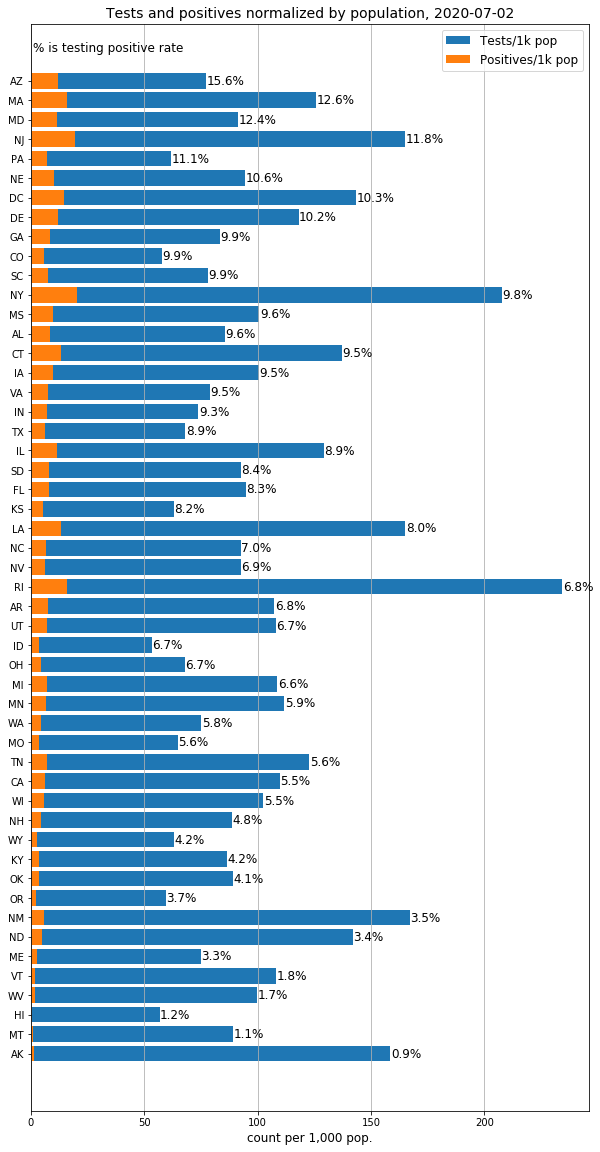

In [23]:
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
positives = covidtracking.pivot(index='date',columns='state', values='positive')
positives=positives.fillna(0)
negatives = covidtracking.pivot(index='date',columns='state', values='negative')
negatives=negatives.fillna(0)

statecodes = pd.read_csv('../expdev07/statecodes.tsv', sep='\t',names=['Abbrev','State'])
statecodes = dict(zip(statecodes['State'],statecodes['Abbrev']))

pop = pd.read_csv('../other3p/state_pop.txt', sep='\t', names=['State','Pop'])
pop = dict(zip([statecodes[c.replace('.','')] for c in pop['State']],pop['Pop']))
#icu
#print(pop,positives.columns)
cols = sorted([c for c in positives.columns if c in pop], reverse=True)
data = list(zip(cols, [max(positives[c])*1e3/pop[c] for c in cols], [max(positives[c]+negatives[c])*1e3/pop[c] for c in cols]))
data = list(sorted(data, key=lambda x: x[1]/x[2]))
plt.rcParams["figure.figsize"] = [10, 20]
fig, ax = plt.subplots()
labels = [c for (c,_,_) in data]
ax.grid(b=True,axis='x')
ax.barh(labels, [x for (_,_,x) in data])
ax.barh(labels, [x for (_,x,_) in data])
for y,d in enumerate(data):
    (_,p,t) = d
    ax.text(t+0.25, y, '{:.1f}%'.format((p/t)*100),size=12,      ha='left', va='center')
ax.text(1,len(data)+0.5, '% is testing positive rate', size=12)
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)
#ax.title('Per state estimated active cases vs ICU beds.')
ax.legend(['Tests/1k pop','Positives/1k pop'], prop=font)
ax.set_title('Tests and positives normalized by population, {}'.format(maxDate.strftime('%Y-%m-%d')),size=14)
ax.set_xlabel('count per 1,000 pop.', size=12)
save_figure(maxDate,'17_tests.png')

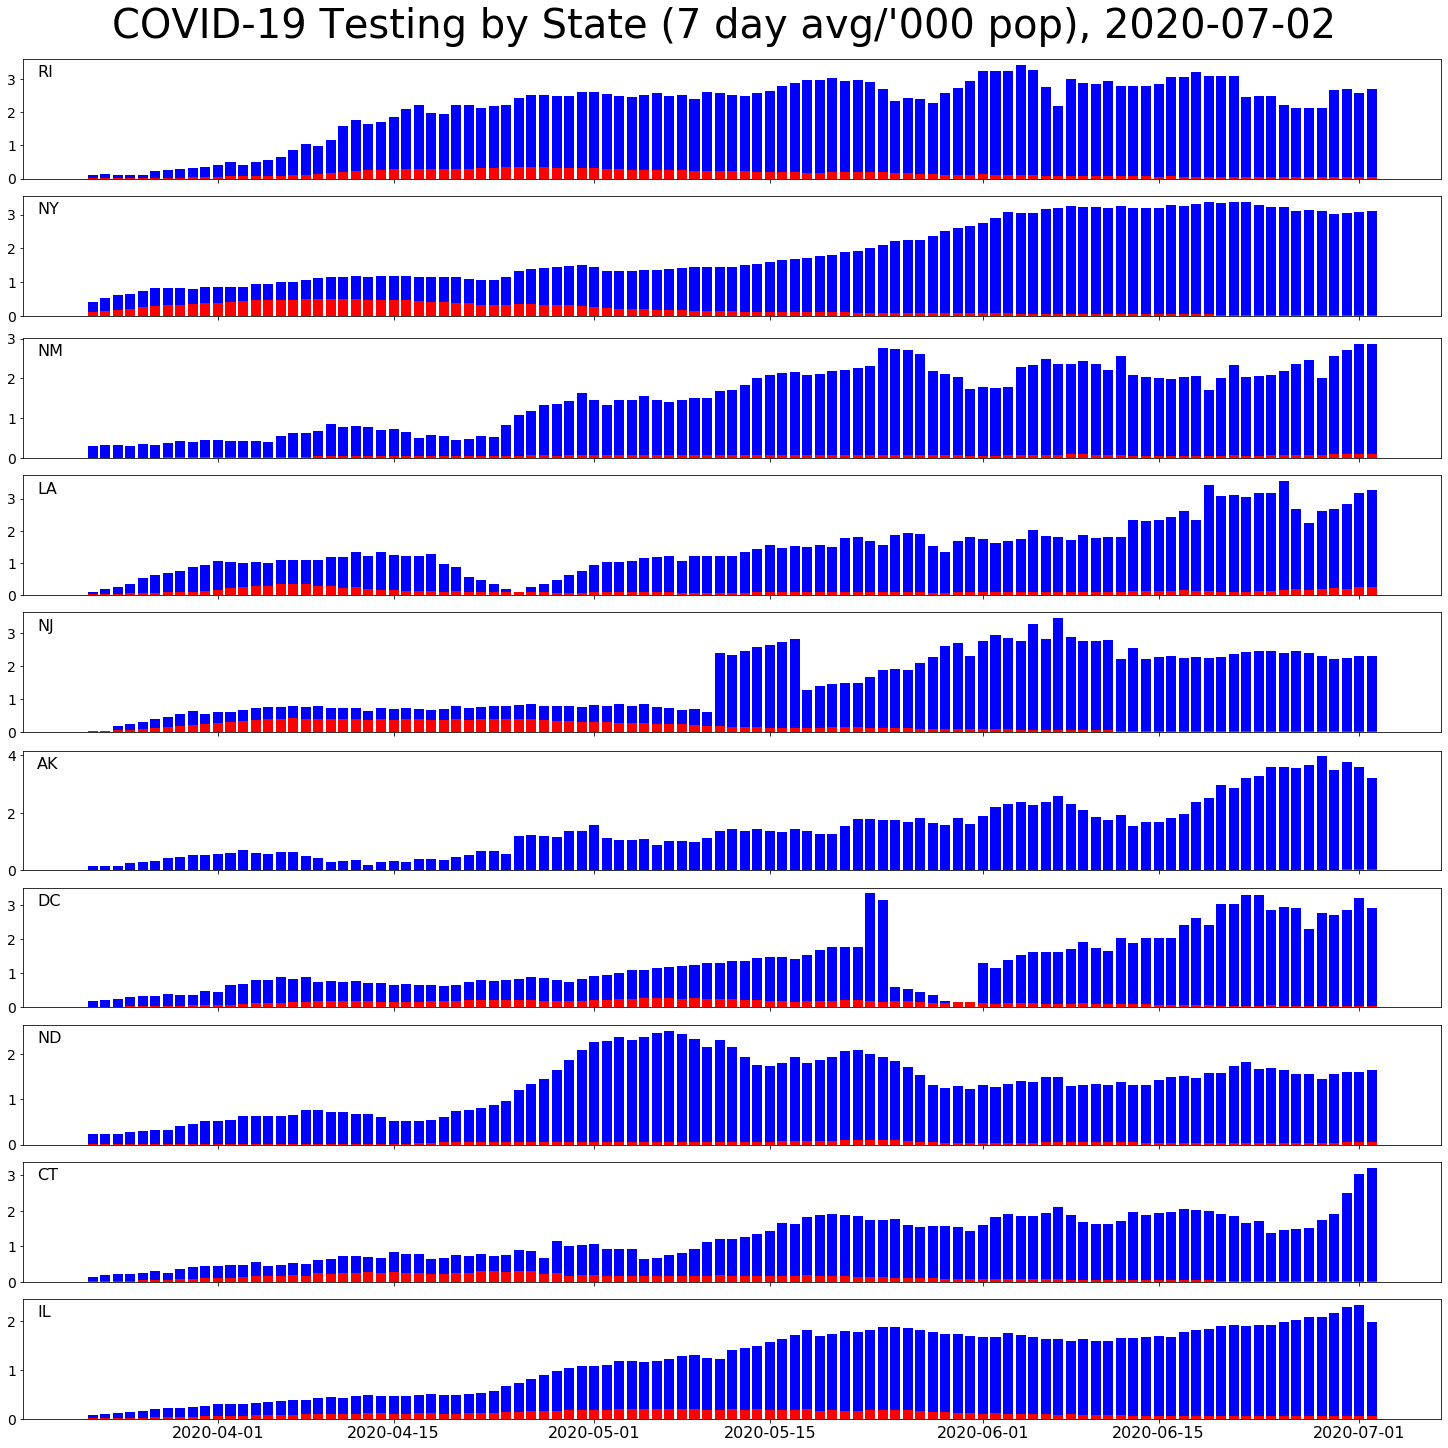

In [24]:
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
positives = covidtracking.pivot(index='date',columns='state', values='positive')
positives=positives.fillna(0)
negatives = covidtracking.pivot(index='date',columns='state', values='negative')
negatives=negatives.fillna(0)

statecodes = pd.read_csv('../expdev07/statecodes.tsv', sep='\t',names=['Abbrev','State'])
statecodes = dict(zip(statecodes['State'],statecodes['Abbrev']))

pop = pd.read_csv('../other3p/state_pop.txt', sep='\t', names=['State','Pop'])
pop = dict(zip([statecodes[c.replace('.','')] for c in pop['State']],pop['Pop']))
#icu
#print(pop,positives.columns)
cols = sorted([c for c in positives.columns if c in pop], key=lambda x: max(positives[x]+negatives[x])*1e3/pop[x], reverse=True)[:10]
dates=positives.index

window = 7
pos_inc = {}
tot_inc = {}

for c in cols:
    pos = positives[c].fillna(0)*1e3/pop[c]
    tot = (positives[c]+negatives[c]).fillna(0)*1e3/pop[c]
    pos_inc[c]=[0]*window+[max(0,(pos[j]-pos[j-window])/window) for j in range(window,len(pos))]
    tot_inc[c]=[0]*window+[max(0,(tot[j]-tot[j-window])/window) for j in range(window,len(tot))]    

offset = 60
    
def plotBars(countries):
    plt.rcParams["figure.figsize"] = [20, 2*len(countries)]
    fig, axs = plt.subplots(len(countries),1, sharex=True,constrained_layout=True)
    for (i,(country,ax)) in enumerate(zip(countries,axs)):
        ax.bar(dates[offset:],tot_inc[country][offset:], color='blue')
        ax.bar(dates[offset:],pos_inc[country][offset:], color='red')
        #ax.plot(dates[offset:],line[country][offset:], color='black')
        #ax.bar(confirmed.index,recovered, color='red')
        
        ax.text(0.01,0.85,country, transform=ax.transAxes, ha='left', size=16)
        ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
        ax.tick_params(axis = 'y', which = 'major', labelsize = 14)
    fig.suptitle('COVID-19 Testing by State ({} day avg/\'000 pop), {}'.format(window, maxDate.strftime('%Y-%m-%d')),size=40)   
plotBars(cols)
save_figure(maxDate,'50_tests.png')

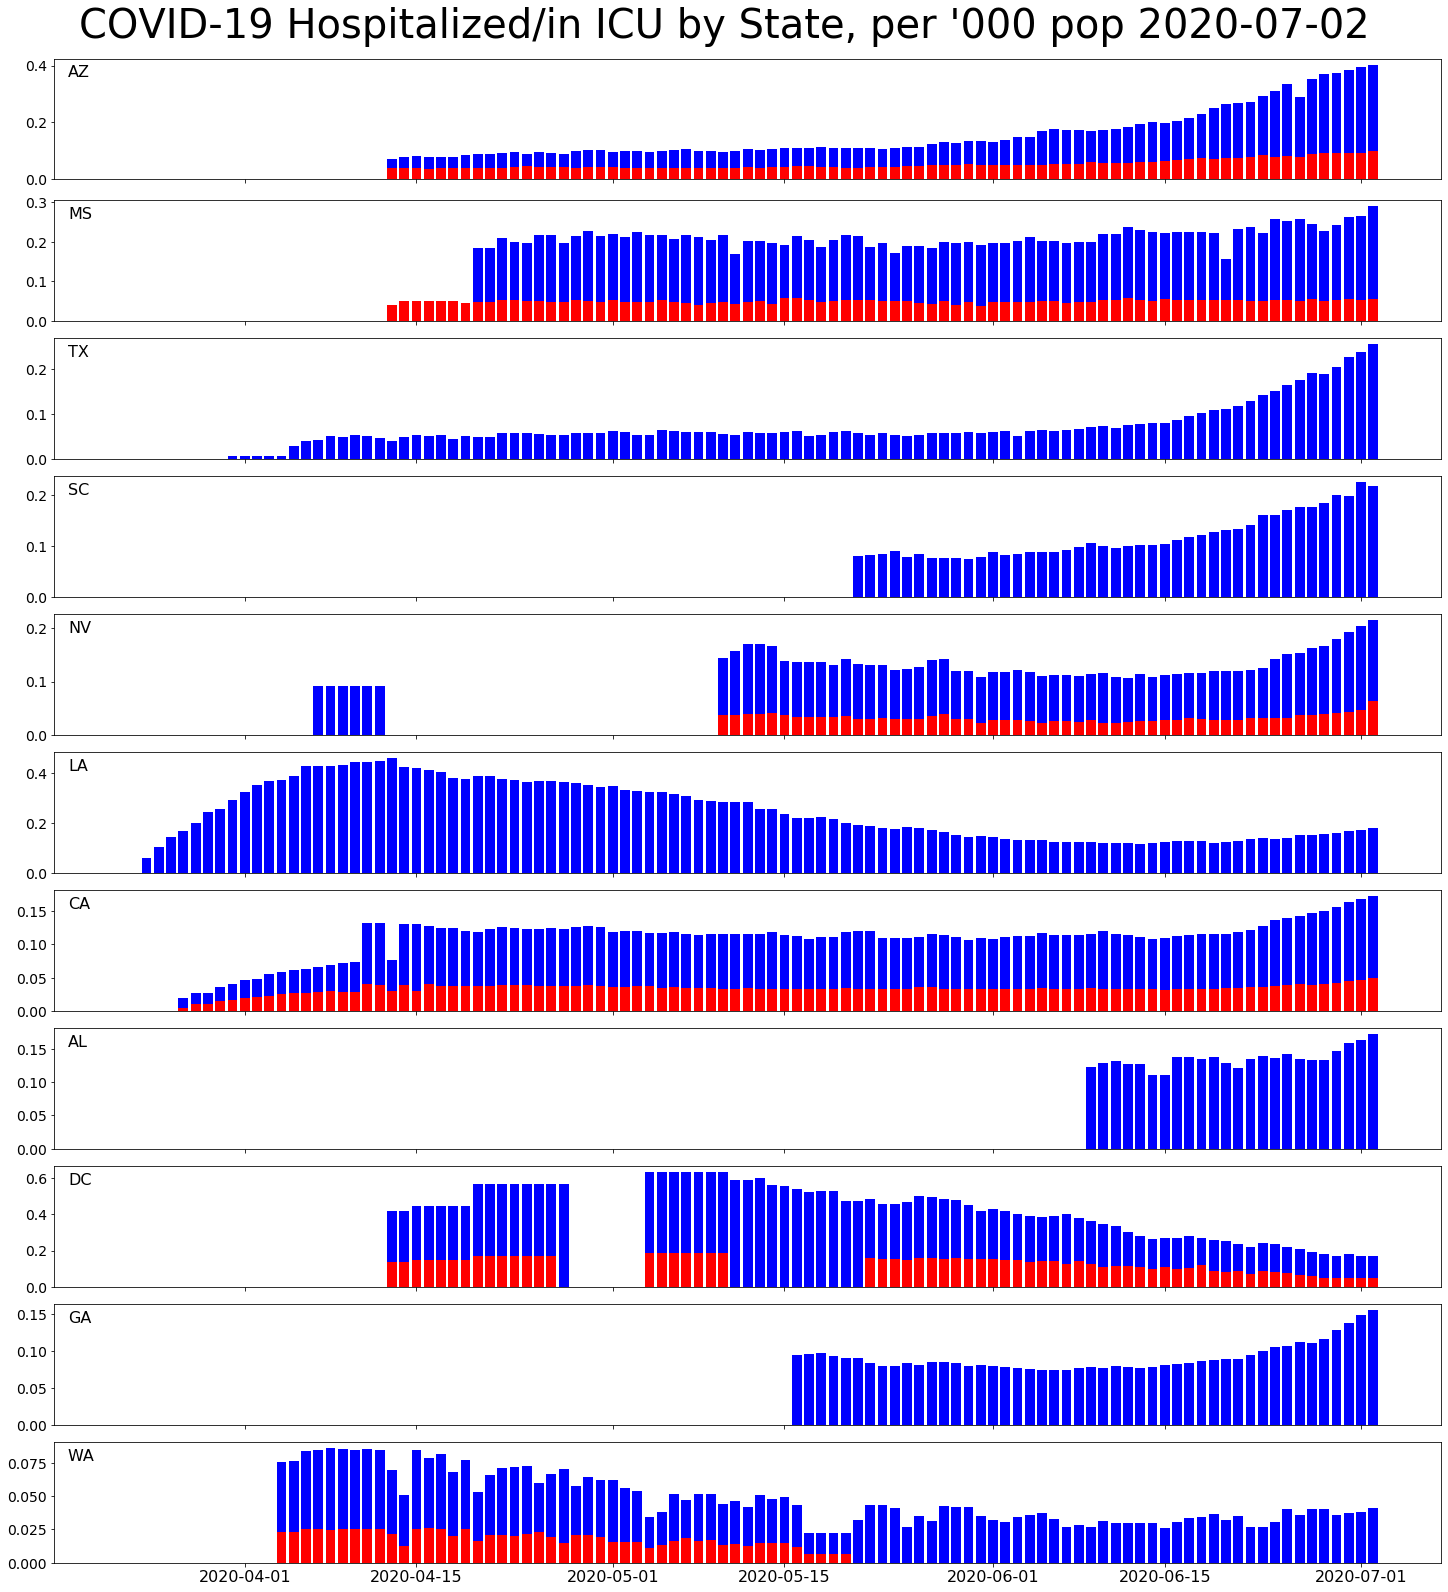

In [25]:
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
positives = covidtracking.pivot(index='date',columns='state', values='inIcuCurrently')
positives=positives.fillna(0)
negatives = covidtracking.pivot(index='date',columns='state', values='hospitalizedCurrently')
negatives=negatives.fillna(0)

statecodes = pd.read_csv('../expdev07/statecodes.tsv', sep='\t',names=['Abbrev','State'])
statecodes = dict(zip(statecodes['State'],statecodes['Abbrev']))

pop = pd.read_csv('../other3p/state_pop.txt', sep='\t', names=['State','Pop'])
pop = dict(zip([statecodes[c.replace('.','')] for c in pop['State']],pop['Pop']))
#icu
#print(pop,positives.columns)
cols = sorted([c for c in positives.columns if c in pop], key=lambda x: negatives[x][-1]*1e3/pop[x], reverse=True)[:10]
if 'WA' not in cols:
    cols.append('WA')
dates=positives.index

window = 1
pos_inc = {}
tot_inc = {}

for c in cols:
    pos = positives[c].fillna(0)*1e3/pop[c]
    tot = negatives[c].fillna(0)*1e3/pop[c]
    pos_inc[c]=[0]*window+[pos[j] for j in range(window,len(pos))]
    tot_inc[c]=[0]*window+[tot[j] for j in range(window,len(tot))]    

#    tot = (positives[c]+negatives[c]).fillna(0)*1e3/pop[c]
#    pos_inc[c]=[0]*window+[max(0,(pos[j]-pos[j-window])/window) for j in range(window,len(pos))]
#    tot_inc[c]=[0]*window+[max(0,(tot[j]-tot[j-window])/window) for j in range(window,len(tot))]    
offset = 60

def plotBars(countries):
    plt.rcParams["figure.figsize"] = [20, 2*len(countries)]
    fig, axs = plt.subplots(len(countries),1, sharex=True,constrained_layout=True)
    for (i,(country,ax)) in enumerate(zip(countries,axs)):
        ax.bar(dates[offset:],tot_inc[country][offset:], color='blue')
        ax.bar(dates[offset:],pos_inc[country][offset:], color='red')
        #ax.plot(dates[offset:],line[country][offset:], color='black')
        #ax.bar(confirmed.index,recovered, color='red')
        
        ax.text(0.01,0.85,country, transform=ax.transAxes, ha='left', size=16)
        ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
        ax.tick_params(axis = 'y', which = 'major', labelsize = 14)
    fig.suptitle('COVID-19 Hospitalized/in ICU by State, per \'000 pop {}'.format(maxDate.strftime('%Y-%m-%d')),size=40)   
plotBars(cols)
save_figure(maxDate,'51_hosp.png')

In [26]:
# Positive rate = p(pos|sympt)*p(test|sympt)*p(sympt) + p(pos|asympt)*p(test|asympt)*p(asympt) 
# In states with highest positive rate, assume p(test|sympt) is ~1 and p(test|asympt) is ~0
data_aug = [(s,p,t,p/t) for (s,p,t) in data]
top_pos_sympt = [pp for (s, p, t,pp) in sorted(data_aug, key=lambda x: x[3], reverse=True)[:5]]
pos_sympt = (np.mean(top_pos_sympt,axis=0),np.std(top_pos_sympt, axis=0))
print(pos_sympt)

# States with lowest positive rate: assume these states are identifying all cases.
# Also assume the ratio of asump/(sympt+asymp) cases is the same everywhere. We can let this range from [0.1:0.5]
asymp_frac = np.arange(0.1,1.1,0.1)
print(asymp_frac)
(s,p,t,pp) = sorted(data_aug, key = lambda x: x[3])[0]
print(s,p,t,pp)
sympt_test = [p*(1-f)/pos_sympt[0] for f in asymp_frac]  # how many tests must be symptomatic
print(sympt_test)
asympt_test = [t - s for s in sympt_test] # tests must be asymptomatic
print(asympt_test) 
asympt_pos = [f*p for f in asymp_frac]
print(asympt_pos)
asympt_pos_rate = [f*p/(t-(p*(1-f)/pos_sympt[0])) for f in asymp_frac]

# take a state in the middle.
(s,p,t,pp) = sorted(data_aug, key = lambda x: x[3])[25]
# some 
    
# what fraction of asympt tests are positive? in this example it's 0 since we attributed all the positives to symptomatic tests
#plt.plot([x for x in range(0,int(t))], [pos_sympt[0]*x for x in range(0,int(t))])


(0.12699535187602903, 0.015319581648817023)
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
AK 1.3902083945621937 158.4441148528115 0.00877412452872512
[9.852231098405593, 8.757538754138306, 7.662846409871016, 6.5681540656037285, 5.473461721336441, 4.378769377069153, 3.284077032801864, 2.189384688534576, 1.094692344267288, 0.0]
[148.59188375440593, 149.6865760986732, 150.7812684429405, 151.8759607872078, 152.97065313147507, 154.06534547574236, 155.16003782000965, 156.25473016427694, 157.34942250854422, 158.4441148528115]
[0.13902083945621937, 0.27804167891243875, 0.41706251836865815, 0.5560833578248775, 0.6951041972810968, 0.8341250367373162, 0.9731458761935357, 1.112166715649755, 1.2511875551059743, 1.3902083945621937]


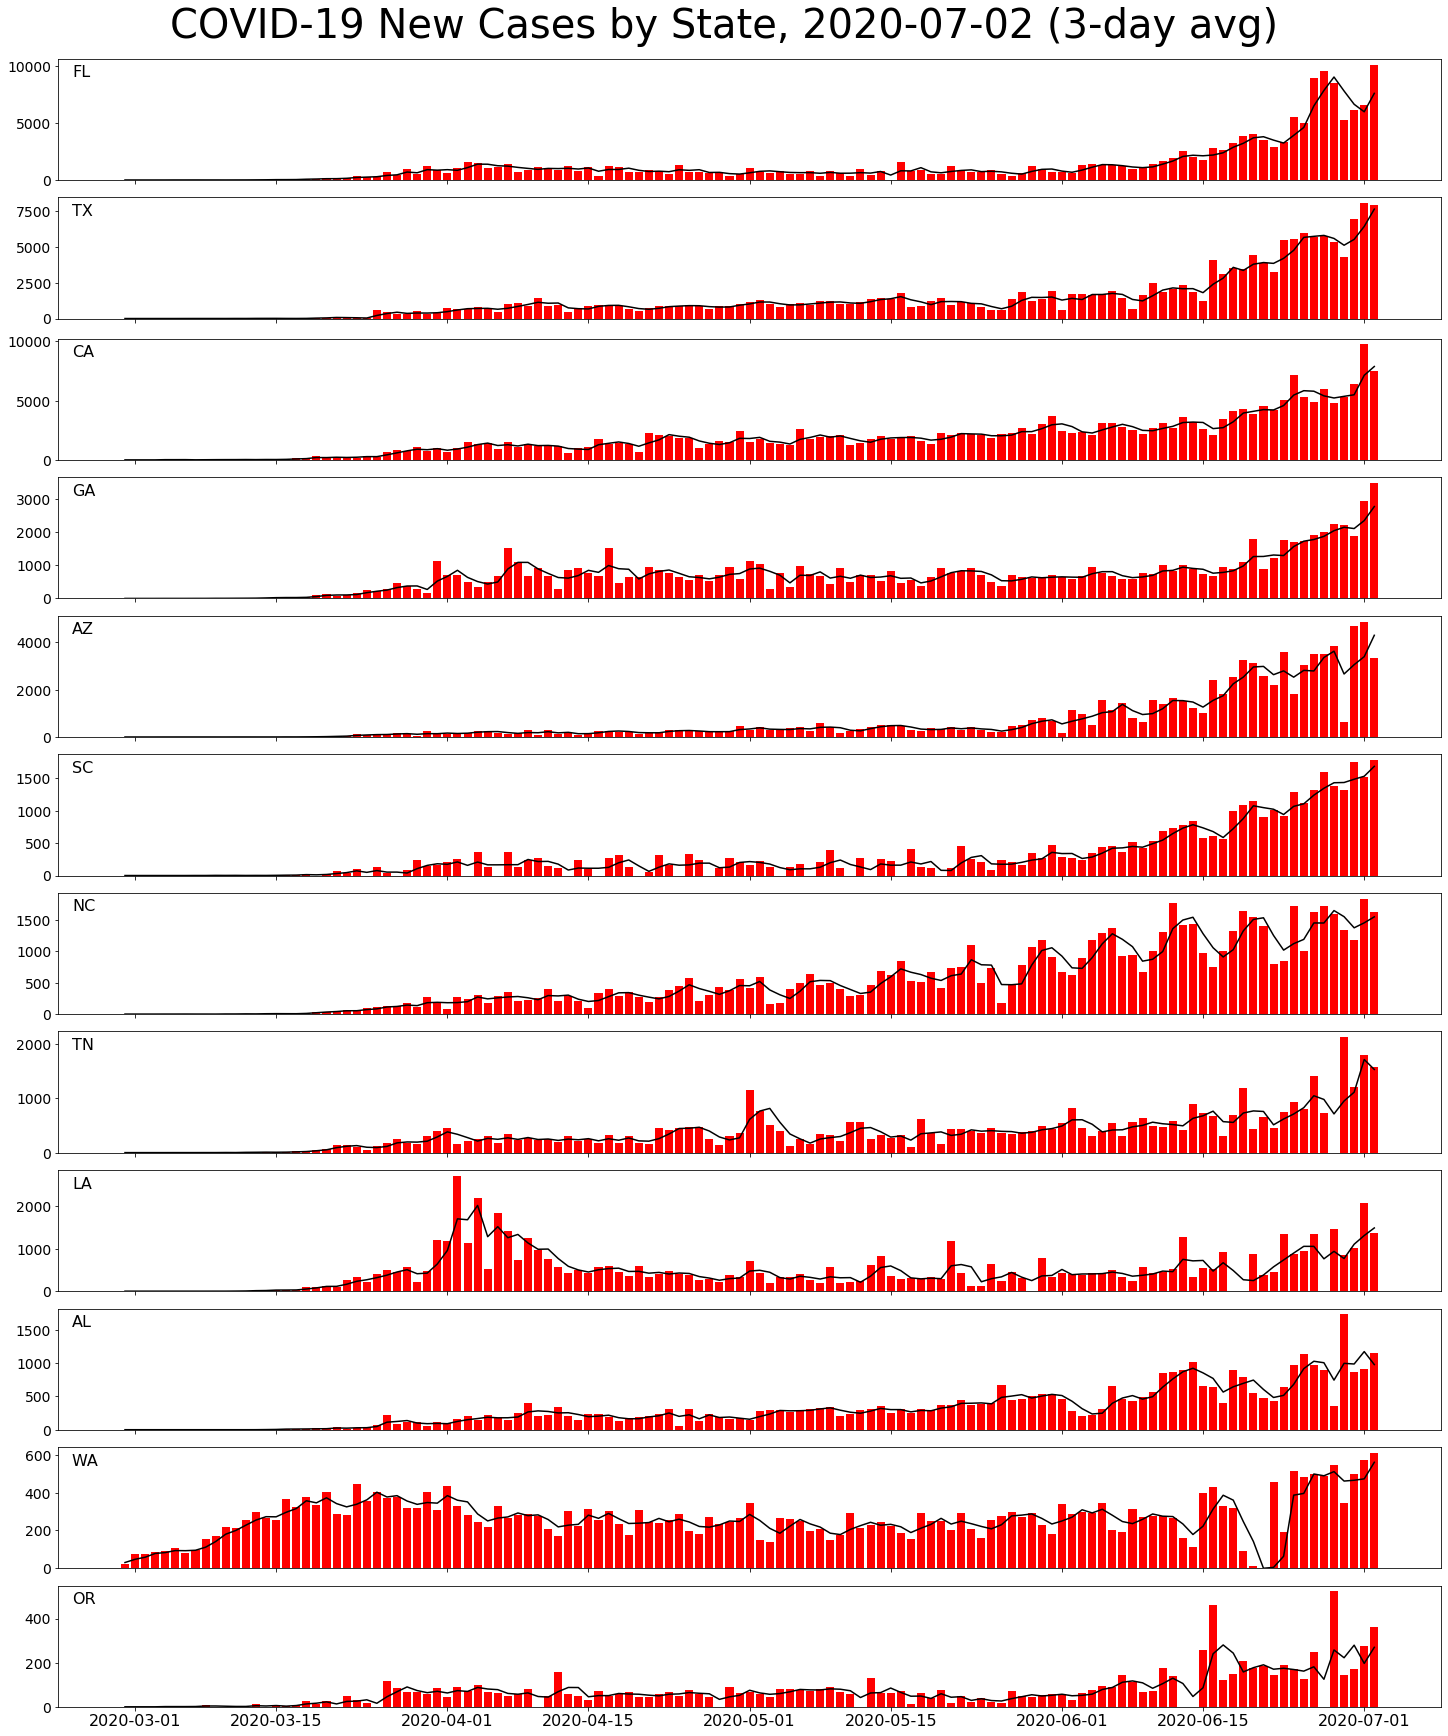

In [27]:
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
#increase = covidtracking.pivot(index='date',columns='state', values='positiveIncrease')
confirmed = covidtracking.pivot(index='date',columns='state', values='positive')

increase = {}
line = {}
window = 3
dates = confirmed.index #[window:]
for c in confirmed:
    cnf = confirmed[c].fillna(0)    
    line[c]=[0]*window+[max(0,(cnf[j]-cnf[j-window])/window) for j in range(window,len(cnf))]
    increase[c]=[0]+[max(0,(cnf[j]-cnf[j-1])) for j in range(1,len(cnf))]

#deaths = covidtracking.pivot(index='date',columns='state', values='death')
#offset = 18

#df = df[[c for c in df.columns if df[c].max()>1000]]

maxDate=max(confirmed.index)

offset=38

def plotBars(countries):
    plt.rcParams["figure.figsize"] = [20, 2*len(countries)]
    fig, axs = plt.subplots(len(countries),1, sharex=True,constrained_layout=True)
    for (i,(country,ax)) in enumerate(zip(countries,axs)):
        ax.bar(dates[offset:],increase[country][offset:], color='red')
        ax.plot(dates[offset:],line[country][offset:], color='black')
        #ax.bar(confirmed.index,recovered, color='red')
        
        ax.text(0.01,0.85,country, transform=ax.transAxes, ha='left', size=16)
        ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
        ax.tick_params(axis = 'y', which = 'major', labelsize = 14)
    fig.suptitle('COVID-19 New Cases by State, {} ({}-day avg)'.format(maxDate.strftime('%Y-%m-%d'), window),size=40)        

statesToPlot = sorted(increase, key=lambda c: increase[c][-1], reverse=True)[:10]
for s in ['WA','GA', 'OR']:
    if s not in statesToPlot:
        statesToPlot.append(s)

#plotBars(['WA','NY','CA','NJ','MA','LA','FL'])
plotBars(statesToPlot)

#print(maxDate)
save_figure(maxDate,'18_newcases.png')

date
2020-01-22        0
2020-01-23        0
2020-01-24        0
2020-01-25        0
2020-01-26        0
              ...  
2020-06-28    30476
2020-06-29    24052
2020-06-30    33846
2020-07-01    46712
2020-07-02    48105
Name: Brazil, Length: 163, dtype: int64
Index(['World', 'US', 'Brazil', 'India', 'South Africa', 'Russia', 'Mexico',
       'Colombia', 'Pakistan', 'Bangladesh', 'Canada', 'Australia',
       'New Zealand', 'Sweden'],
      dtype='object')


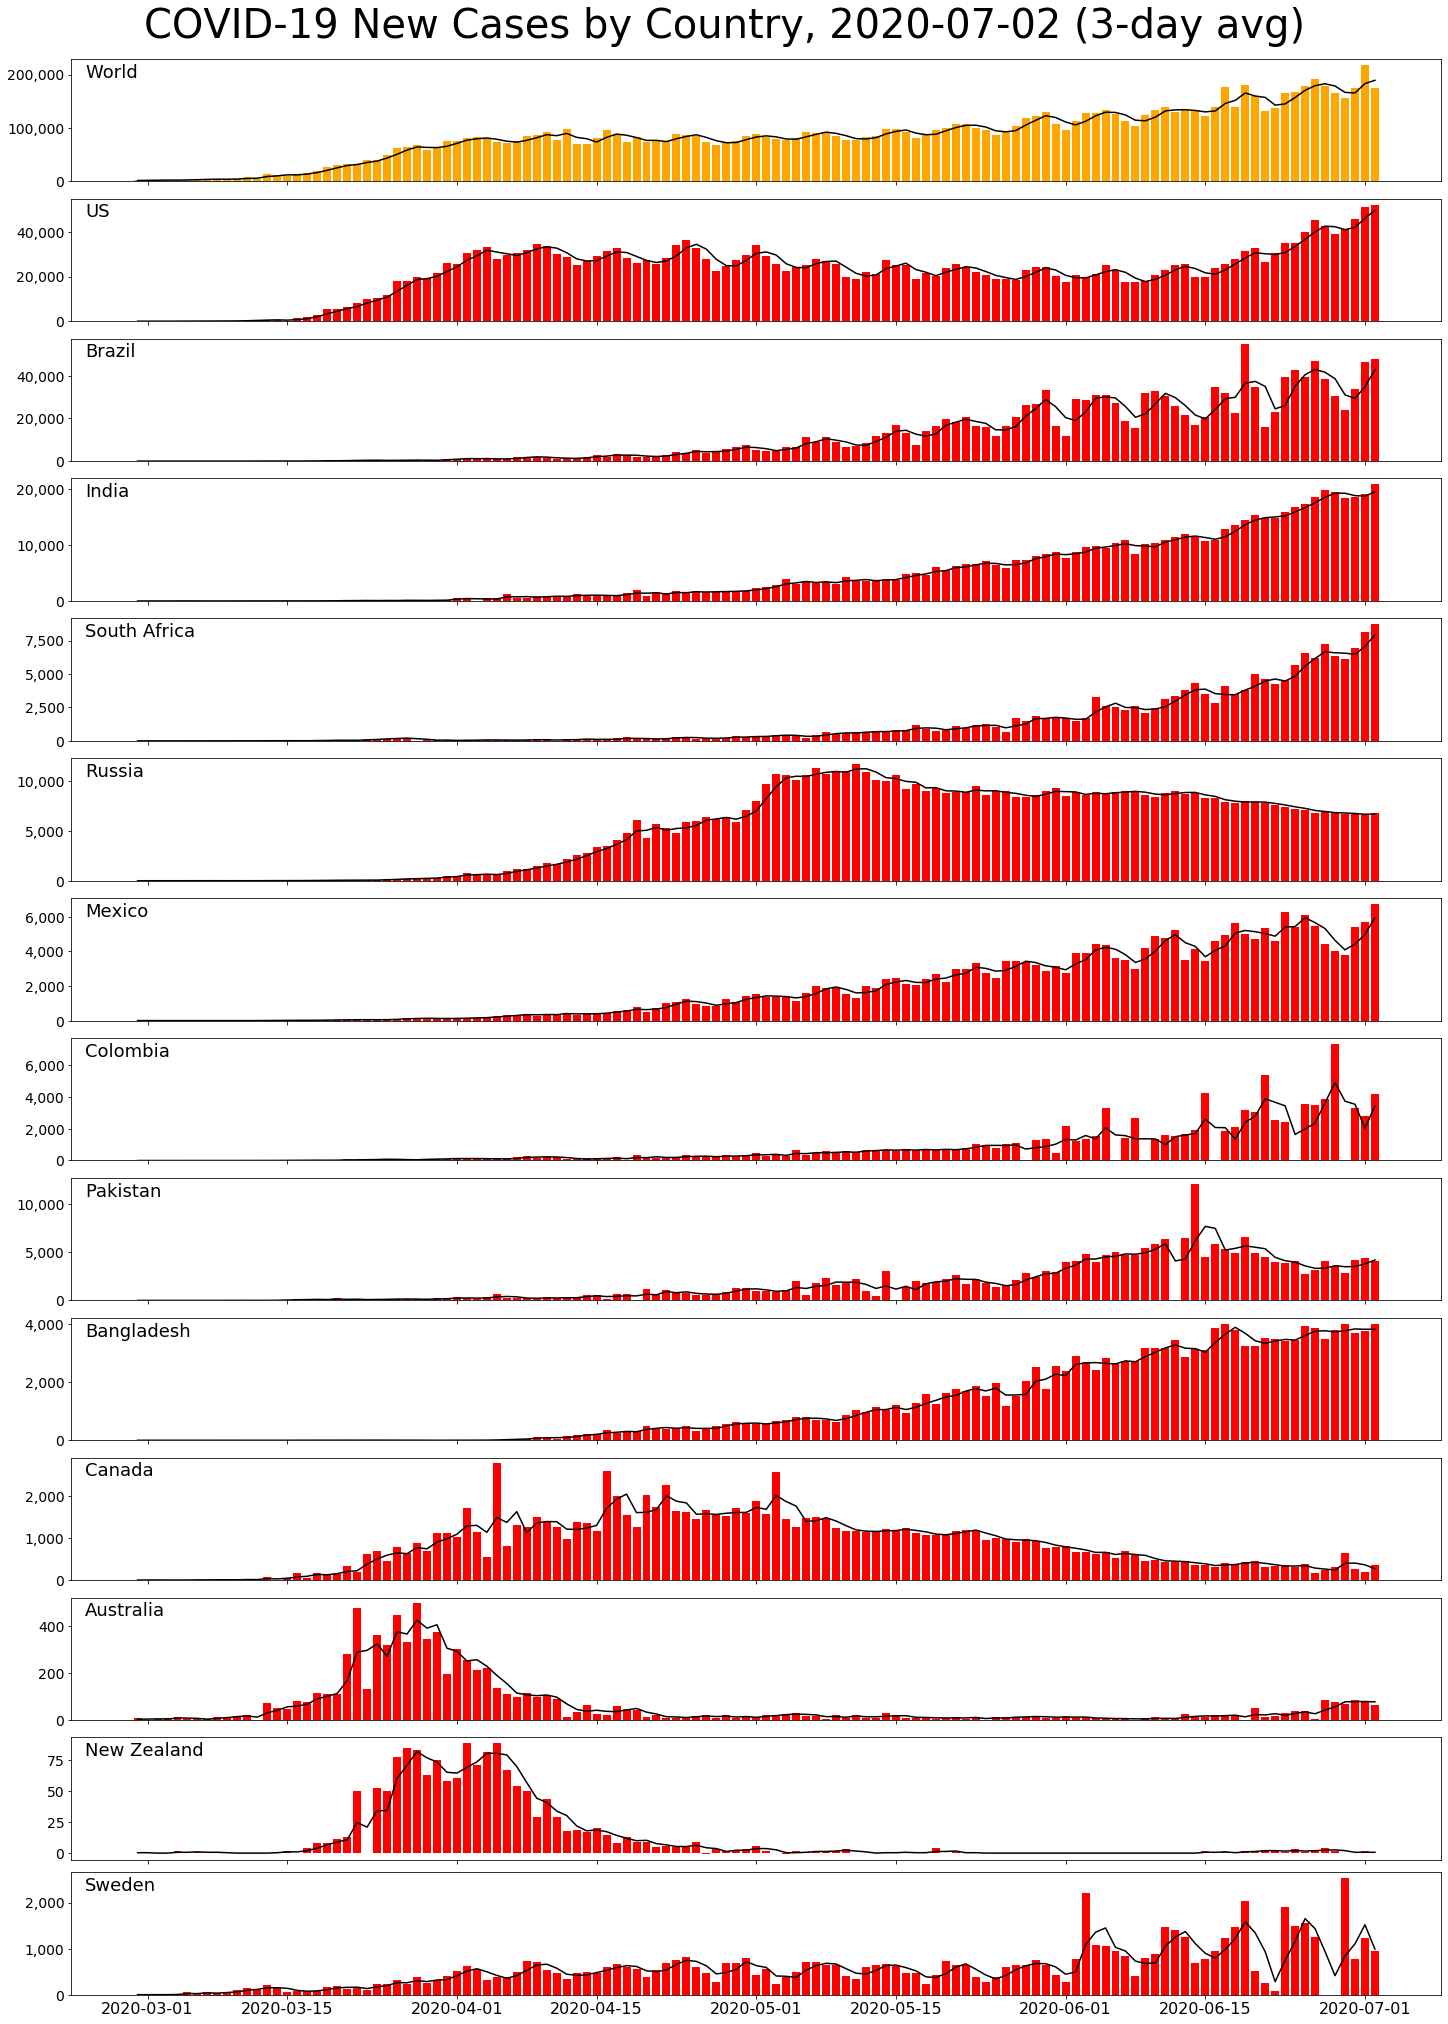

In [28]:
df = raw
#df['Region']= (df['Province/State'].fillna('')+', '+df['Country/Region']).apply(lambda x: x if x[0]!=',' else x[2:])
df['Region'] = df['Country/Region']
#print(df['Region'])
df=df.groupby('Region').sum()

# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]
#threshold=50
#df = df[df[last_date]>threshold]
#df = df[df.index.isin(['US','France','Germany','Italy','Spain'])]
#df = df.groupby(df.index=='US').sum()
#df.index = ['World']

df['Region']=df.index
df=df.melt(id_vars='Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]

line={'World':[0]*len(df['Canada'])}
df['World'] = [0]*len(df['Canada'])
window = 3
for c in df.columns:
    if c=='World':
        continue
    line[c] = [0]*window+[(df[c][i]-df[c][i-window])/window for i in range(window,len(df[c]))]
    df[c] = [0]+[(df[c][i]-df[c][i-1]) for i in range(1,len(df[c]))]
    line['World'] = np.add(line['World'],line[c])    
    df['World'] = np.add(df['World'],df[c])
    #print(line[c],line['World'])
print(df['Brazil'])
countries = [c for c in sorted(df.columns, key=lambda x: df[x][-1], reverse=True)[:10]]
for c in ['Canada','Australia','New Zealand', 'Sweden']:
    if c not in countries:
        countries.append(c)
df = df[countries]
       
print(df.columns)
countries=df.columns
# Jan 22 is the start. So index from 38: for March 1 
offset = 38
dates=df.index[offset:]
maxDate = max(df.index)
plt.rcParams["figure.figsize"] = [20, 2*len(countries)]
fig, axs = plt.subplots(len(countries),1, sharex=True,constrained_layout=True)
for (i,(country,ax)) in enumerate(zip(countries,axs)):
    color='orange' if country=='World' else 'red'
    ax.bar(dates,df[country][offset:], color=color)
    ax.plot(dates,line[country][offset:], color='black')
    #ax.bar(confirmed.index,recovered, color='red')
    ax.get_yaxis().set_major_formatter(
        ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.text(0.01,0.85,country, transform=ax.transAxes, ha='left', size=18)
    ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
    ax.tick_params(axis = 'y', which = 'major', labelsize = 14)
    
fig.suptitle('COVID-19 New Cases by Country, {} ({}-day avg)'.format(maxDate.strftime('%Y-%m-%d'),window),size=40)        
    

save_figure(maxDate,'19_newcases_country.png')

In [29]:
df['World'][-1]

174349

Index(['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Northwest Territories', 'Nova Scotia',
       'Ontario', 'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon'],
      dtype='object')


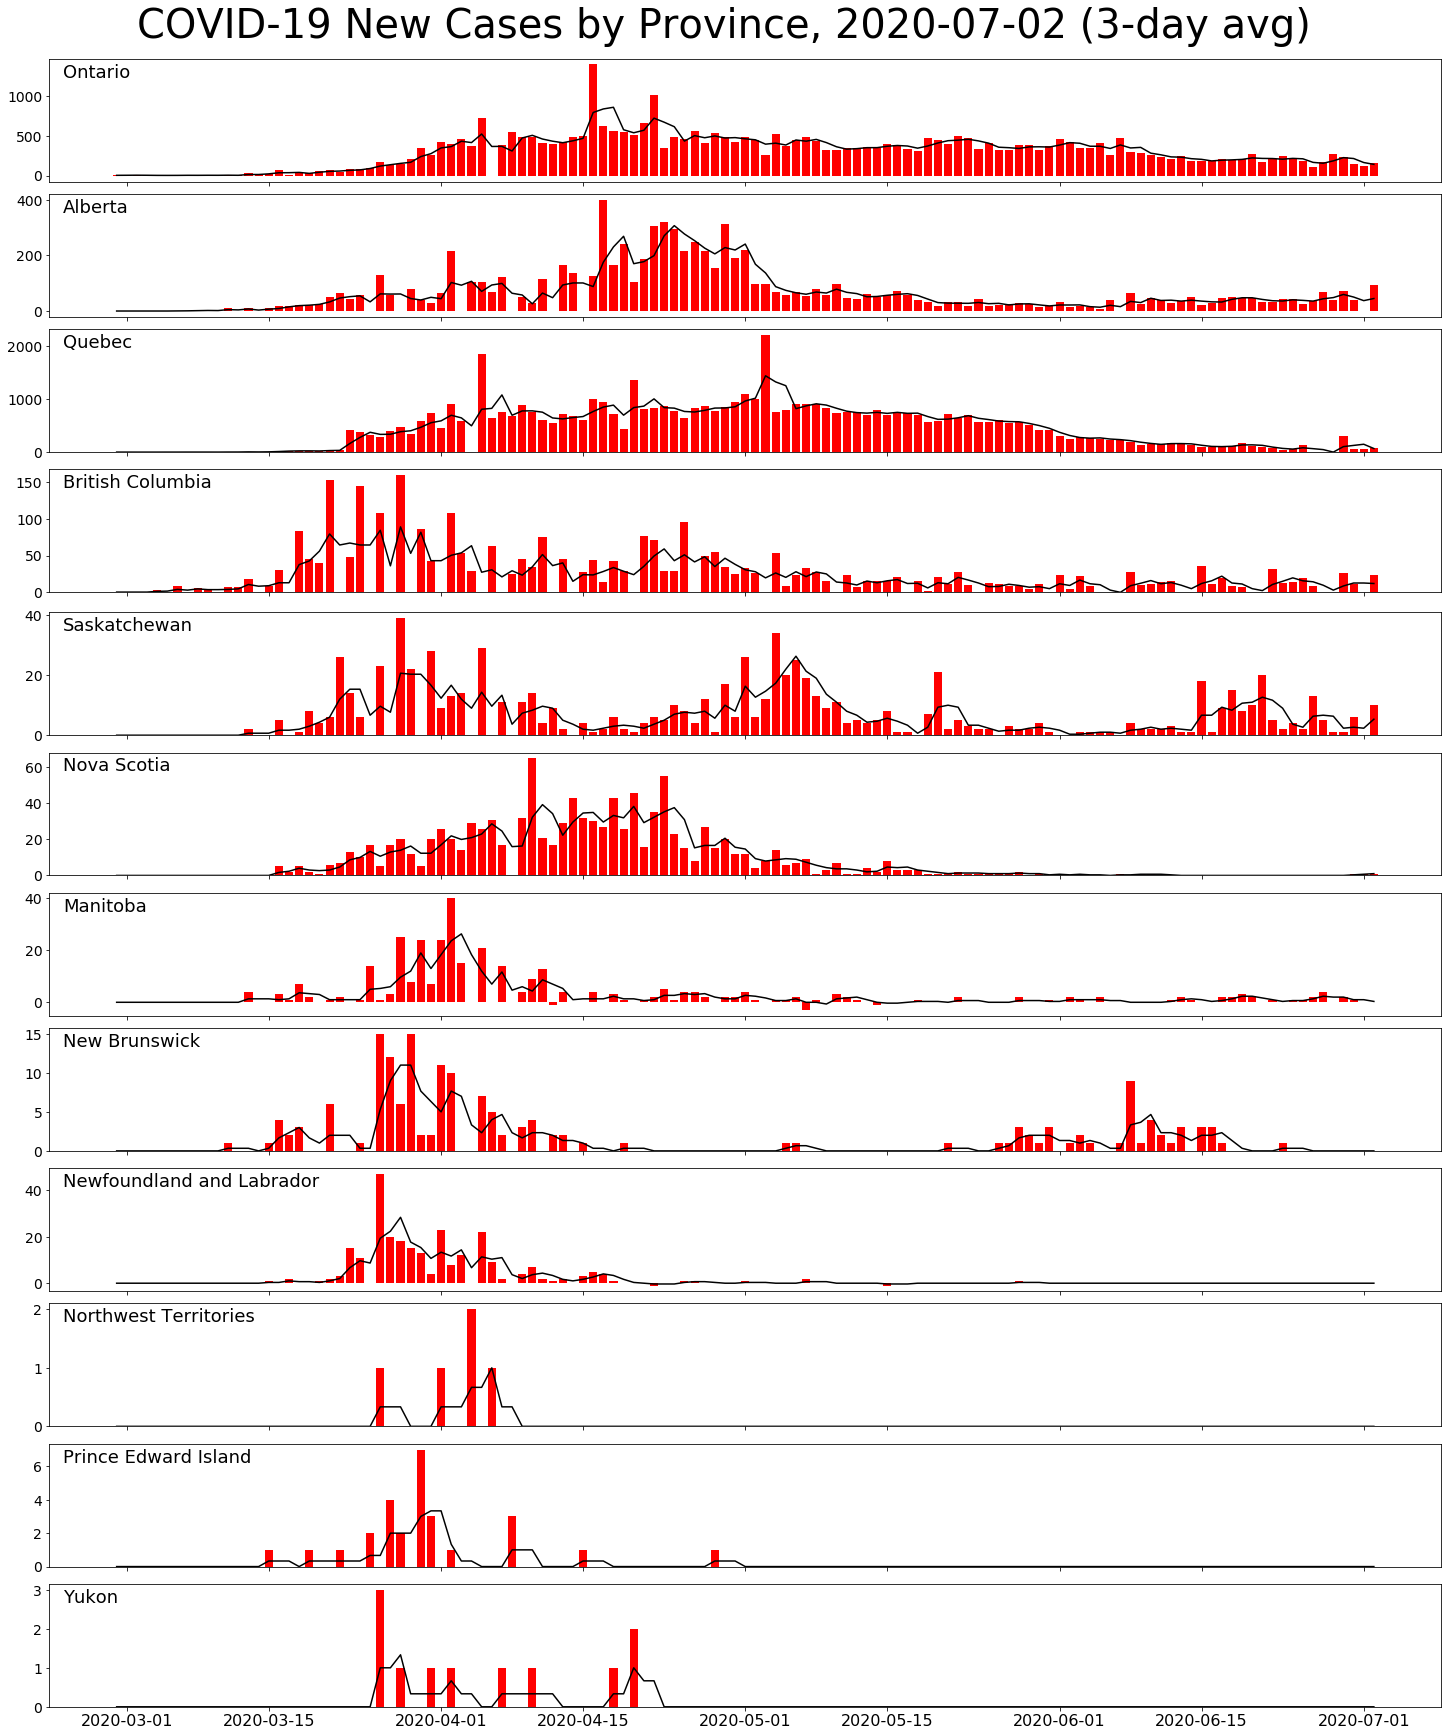

In [30]:

df = raw[raw['Country/Region']=='Canada']
df=df.groupby('Province/State').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

df['Province']=df.index
df=df.melt(id_vars='Province',var_name='date', value_name='Confirmed').pivot(index='date',columns='Province')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
for c in ['Recovered', 'Diamond Princess', 'Grand Princess']:
    if c in df:
        del df[c] 

line={}
window = 3
for c in df.columns:
    line[c] = [0]*window+[(df[c][i]-df[c][i-window])/window for i in range(window,len(df[c]))]
    df[c] = [0]+[(df[c][i]-df[c][i-1]) for i in range(1,len(df[c]))]
    
#df = df[[c for c in sorted(df.columns, key=lambda x: df[x][-1], reverse=True)[:10]+['Australia','New Zealand']]]
print(df.columns)
countries=sorted(df.columns, key=lambda x: df[x][-1], reverse=True)
# Jan 22 is the start. So index from 38: for March 1 
offset = 38
dates=df.index[offset:]
maxDate = max(df.index)
plt.rcParams["figure.figsize"] = [20, 2*len(countries)]
fig, axs = plt.subplots(len(countries),1, sharex=True,constrained_layout=True)
for (i,(country,ax)) in enumerate(zip(countries,axs)):
    ax.bar(dates,df[country][offset:], color='red')
    ax.plot(dates,line[country][offset:], color='black')
    #ax.bar(confirmed.index,recovered, color='red')
    ax.text(0.01,0.85,country, transform=ax.transAxes, ha='left', size=18)
    ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
    ax.tick_params(axis = 'y', which = 'major', labelsize = 14)
    
fig.suptitle('COVID-19 New Cases by Province, {} ({}-day avg)'.format(maxDate.strftime('%Y-%m-%d'),window),size=40)        
    

save_figure(maxDate,'20_newcases_province.png')

Index(['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Northwest Territories', 'Nova Scotia',
       'Ontario', 'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon'],
      dtype='object')


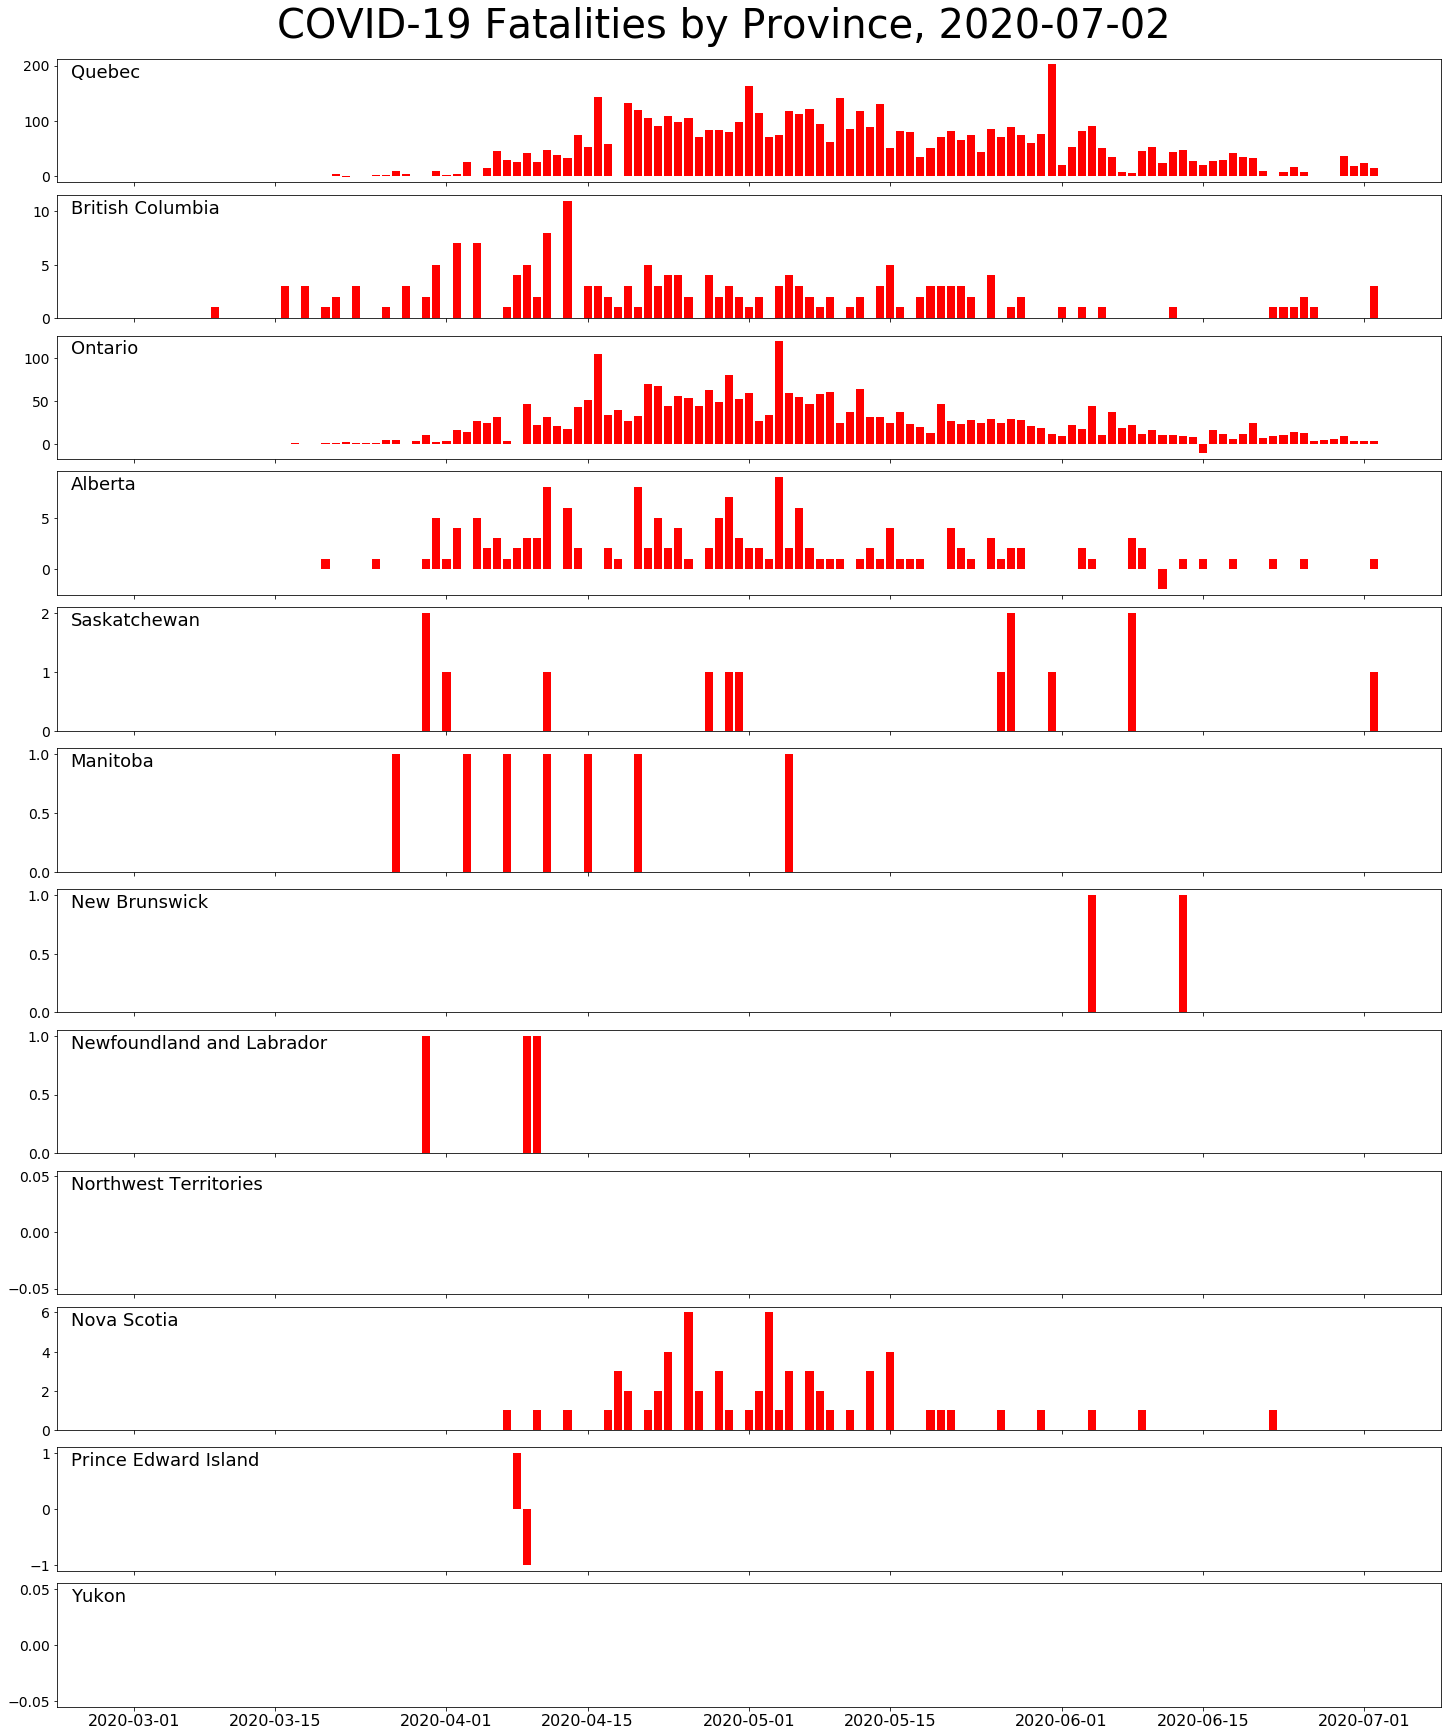

In [31]:

df = raw_deaths[raw_deaths['Country/Region']=='Canada']
df=df.groupby('Province/State').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

df['Province']=df.index
df=df.melt(id_vars='Province',var_name='date', value_name='Confirmed').pivot(index='date',columns='Province')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
for c in ['Recovered', 'Diamond Princess', 'Grand Princess']:
    if c in df:
        del df[c] 

window = 1
for c in df.columns:
    df[c] = [0]*window+[(df[c][i]-df[c][i-window])/window for i in range(window,len(df[c]))]
    
#df = df[[c for c in sorted(df.columns, key=lambda x: df[x][-1], reverse=True)[:10]+['Australia','New Zealand']]]
print(df.columns)
countries=sorted(df.columns, key=lambda x: df[x][-1], reverse=True)
# Jan 22 is the start. So index from 38: for March 1 
offset = 38
dates=df.index[offset:]
maxDate = max(df.index)
plt.rcParams["figure.figsize"] = [20, 2*len(countries)]
fig, axs = plt.subplots(len(countries),1, sharex=True,constrained_layout=True)
for (i,(country,ax)) in enumerate(zip(countries,axs)):
    ax.bar(dates,df[country][offset:], color='red')
    #ax.bar(confirmed.index,recovered, color='red')
    ax.text(0.01,0.85,country, transform=ax.transAxes, ha='left', size=18)
    ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
    ax.tick_params(axis = 'y', which = 'major', labelsize = 14)
    
fig.suptitle('COVID-19 Fatalities by Province, {}'.format(maxDate.strftime('%Y-%m-%d')),size=40)        
    

save_figure(maxDate,'21_fatalities_province.png')

['China', 'India', 'US', 'Indonesia', 'Pakistan', 'Brazil', 'Nigeria', 'Bangladesh', 'Russia', 'Mexico', 'Japan', 'Ethiopia', 'Philippines', 'Egypt', 'Turkey', 'Iran', 'Germany', 'Thailand', 'United Kingdom', 'France', 'Italy', 'South Africa', 'Kenya', 'Korea, South']
[[2.30103    1.        ]
 [5.94542771 1.        ]] [1.82197019e+01 2.61845695e+05]
['Colombia', 'Spain', 'Argentina', 'Algeria', 'Sudan', 'Ukraine', 'Iraq', 'Afghanistan', 'Poland', 'Canada', 'Morocco', 'Saudi Arabia', 'Uzbekistan', 'Peru', 'Malaysia', 'Ghana', 'Yemen', 'Nepal', 'Madagascar', 'Cameroon', 'Australia', 'Niger', 'Sri Lanka', 'Mali']
[[2.30103    1.        ]
 [5.03665284 1.        ]] [   30.28685224 19203.76265565]
['Romania', 'Malawi', 'Chile', 'Kazakhstan', 'Zambia', 'Guatemala', 'Ecuador', 'Netherlands', 'Senegal', 'Somalia', 'Guinea', 'Rwanda', 'Benin', 'Tunisia', 'Belgium', 'Haiti', 'Cuba', 'South Sudan', 'Dominican Republic', 'Czechia', 'Greece', 'Jordan', 'Portugal', 'Azerbaijan', 'Sweden']
[[2.30103  

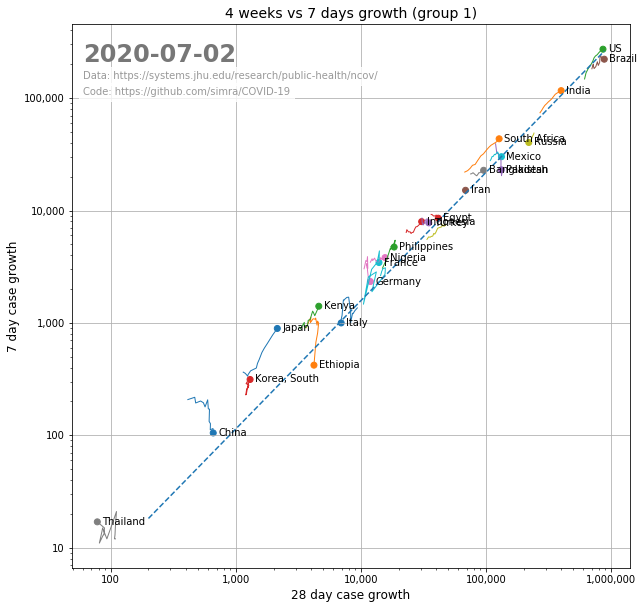

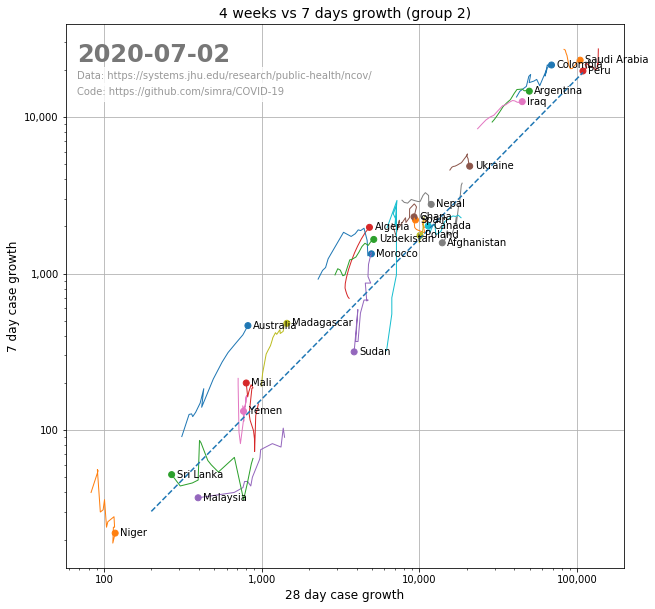

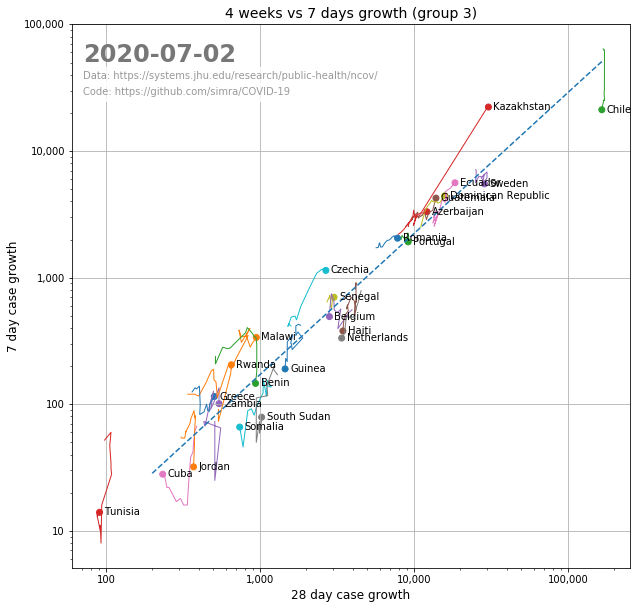

In [32]:
df=raw.groupby('Country/Region').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

df = df[(df.index.isin(['Canada','Japan', 'Australia'])) | (df[last_date]>1000)]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
#del df['Cruise Ship']
maxDate=max(df.index)


wpp = pd.read_csv('../wpp/WPP2019_TotalPopulationBySex.csv')
wpp=wpp[(wpp['Time']==2020) & (wpp['Variant']=='Medium')]
wpp = dict(zip(wpp['Location'],wpp['PopTotal']))
wpp['Iran']=wpp['Iran (Islamic Republic of)']
wpp['US']=wpp['United States of America']
wpp['Korea, South']= wpp['Republic of Korea']
wpp['Russia'] = wpp['Russian Federation']

columnsFiltered = [c for c in df.columns if c in wpp and wpp[c]>=10000]
df = df[columnsFiltered]
#for c in df.columns:
#    df[c]=df[c]/wpp[c]
#print(df.columns)

for i in range(3):
    plt.rcParams["figure.figsize"] = [10, 10]
    fig, ax = plt.subplots()
    growth = {}
    growth_l = {}
    points = []
    start = int(i*len(df.columns)/3)
    end = int((i+1)*len(df.columns)/3)
    columns = sorted(df.columns, key=lambda x:wpp[x], reverse=True)[start:end]
    print(columns)
    markers = [item for sublist in ['oxds+*']*ceil(len(columns)/5) for item in sublist]    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    colorsToUse=colors*ceil(len(columns)/len(colors))
    long_window= 4*7
    start = long_window
    for c,m,col in zip(columns,markers,colorsToUse):
        #growth[c] = [(pow(df[c][i]/max(1.0,df[c][i-6]),1.0/7)-1)*100 if df[c][i]>200 else float('nan') for i in range(20,len(df[c]))]
        growth[c] = [df[c][i]-df[c][i-6] if (df[c][i]>200 and df[c][i]>df[c][i-6]) else float('nan') for i in range(start,len(df[c]))]
        growth_l[c] = [df[c][i]-df[c][i-long_window] if (df[c][i]>200 and df[c][i]>df[c][i-long_window]) else float('nan') for i in range(start,len(df[c]))]
        #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
        ax.plot(growth_l[c][-14:], growth[c][-14:], linewidth=1,color=col)
        points.append([growth_l[c][-1],growth[c][-1],c])

    ax.scatter([p[0] for p in points],[p[1] for p in points],color=colorsToUse[:len(points)])   
    for (x,y,txt) in points:
        ax.annotate(txt,(x,y), xytext=(5,0), va='center', textcoords='offset points')
    font = font_manager.FontProperties(family='sans-serif',
                                       weight='normal',
                                       style='normal', size=12)



    from math import log10 as log
    x = [log(growth_l[c][-1]) if growth_l[c][-1]>0 else 0 for c in growth]
    y = [log(growth[c][-1]) if growth[c][-1]>0 else 0 for c in growth]
    #print(x,y)
    model = np.polyfit(x,y,1)
    model
    model_x = np.array([[log(200),1],[max(x),1]])
    model_y = np.power(10,model_x.dot(model))
    print(model_x,model_y)
    ax.plot(np.power(10,model_x[:,0]), model_y, linestyle='--')

    ax.grid()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.get_xaxis().set_major_formatter(
        ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.get_yaxis().set_major_formatter(
        ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    #ax.yaxis.set_label_position("right")
    #ax.set_ylim([0,50])
    ax.set_xlabel('28 day case growth', size=12)
    ax.set_ylabel('7 day case growth', size=12)
    ax.set_title('4 weeks vs 7 days growth (group {})'.format(i+1), size=14)
#ax.legend(df.columns, prop=font)    
#plt.ylim((0,100))
    ax.text(0.02, 0.93, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='left', weight=800)
    ax.text(0.02, 0.90, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='left', size=10,
            color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    ax.text(0.02, 0.87, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='left', size=10,
            color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    save_figure(maxDate,'10_c_{}_countvsgrowth_8week.png'.format(i))

{'King County': 2233163, 'Pierce County': 891299, 'Snohomish County': 814901, 'Spokane County': 514631, 'Clark County': 481857, 'Thurston County': 286419, 'Kitsap County': 269805, 'Yakima County': 251446, 'Whatcom County': 225685, 'Benton County': 201877, 'Skagit County': 128206, 'Cowlitz County': 108987, 'Grant County': 97331, 'Franklin County': 94347, 'Island County': 84460, 'Lewis County': 79604, 'Chelan County': 77036, 'Clallam County': 76737, 'Grays Harbor County': 73901, 'Mason County': 65507, 'Walla Walla County': 60922, 'Whitman County': 49791, 'Kittitas County': 47364, 'Stevens County': 45260, 'Douglas County': 42907, 'Okanogan County': 42132, 'Jefferson County': 31729, 'Asotin County': 22610, 'Klickitat County': 22107, 'Pacific County': 22036, 'Adams County': 19759, 'San Juan County': 17128, 'Pend Oreille County': 13602, 'Skamania County': 11924, 'Lincoln County': 10740, 'Ferry County': 7649, 'Wahkiakum County': 4426, 'Columbia County': 4059, 'Garfield County': 2247}
[11.6767

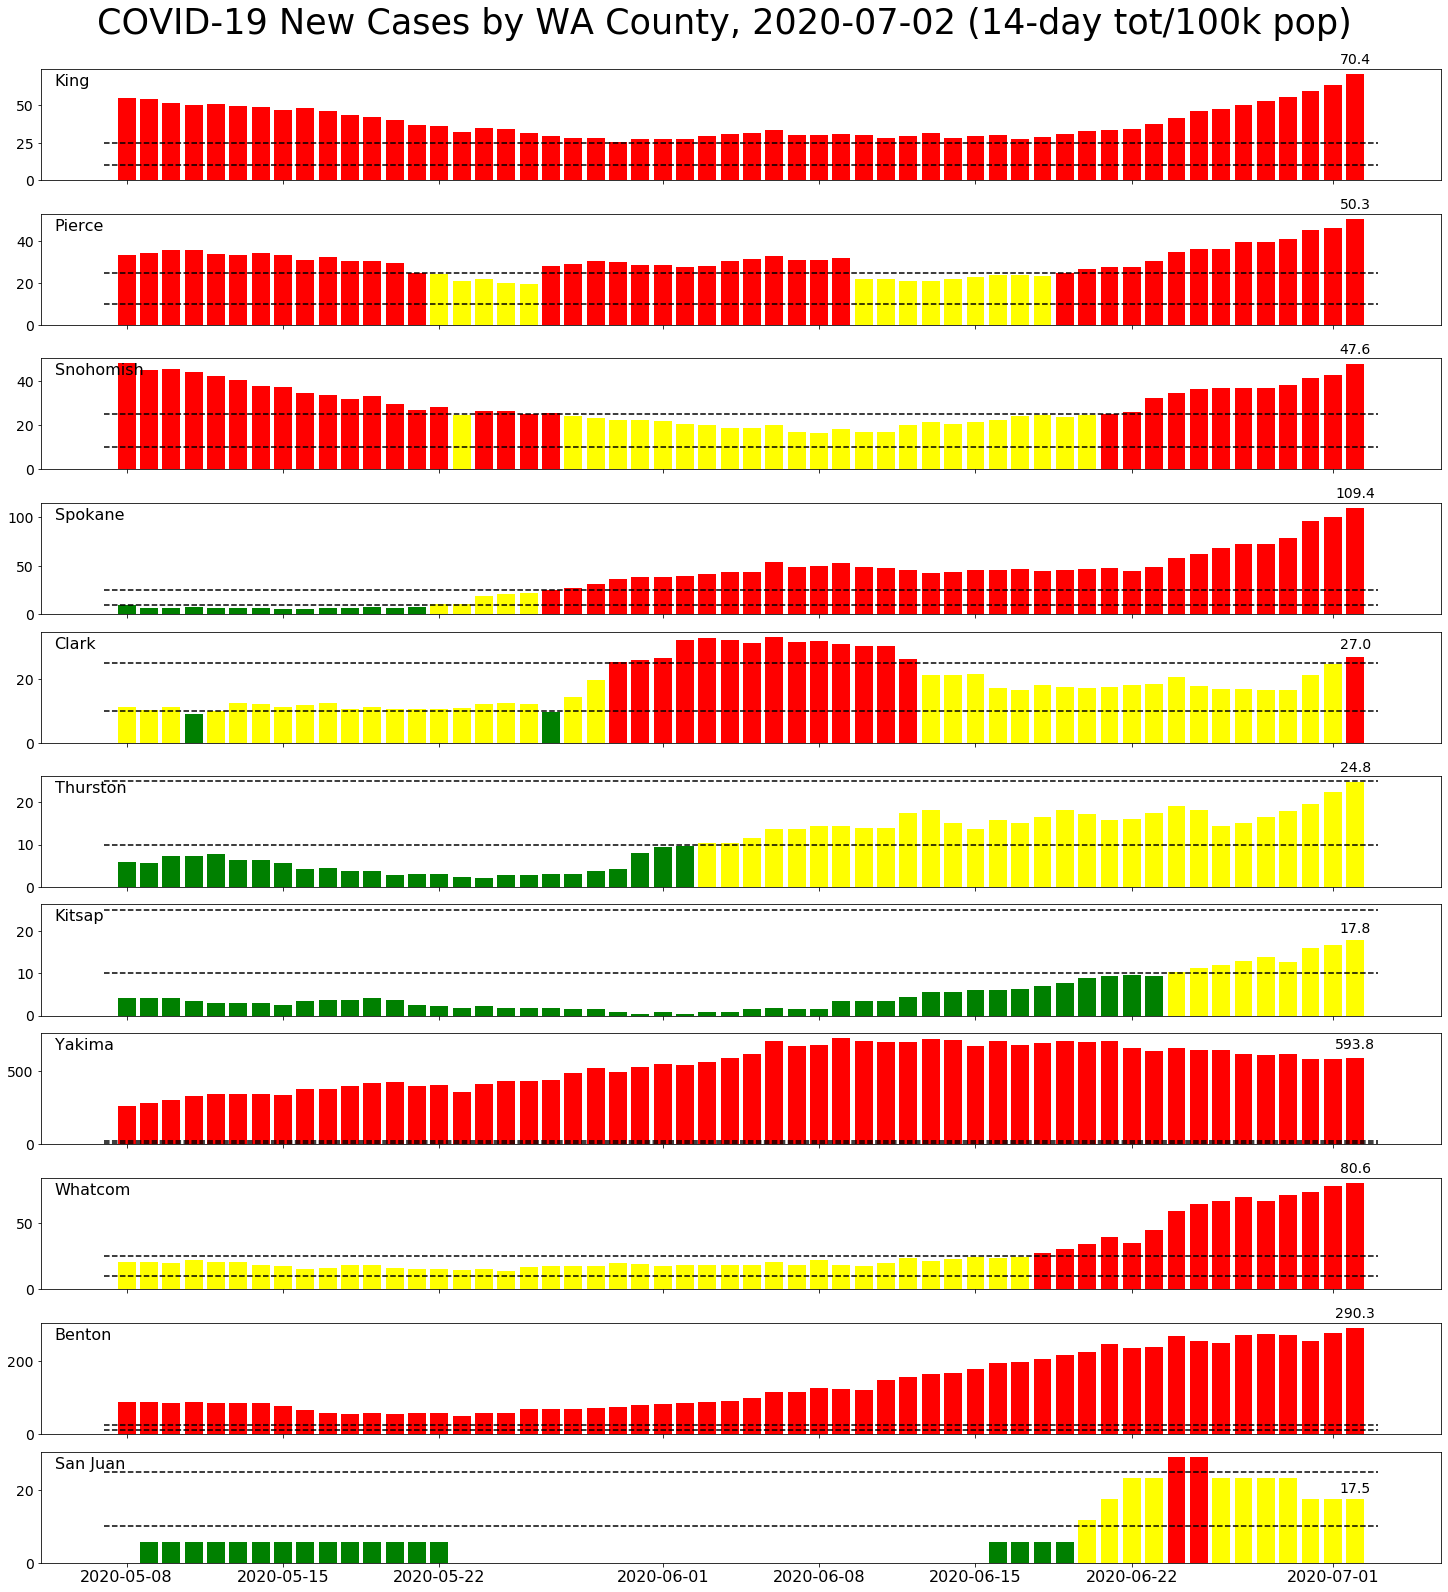

In [33]:
# Load Data
import json
def load_raw_counties(fn):
    datapath = os.path.join('../csse_covid_19_data/csse_covid_19_time_series/', fn)

    #datapath = '../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    
    raw = pd.read_csv(datapath)
    #raw= raw.replace('Mainland China','China')
    raw = raw[raw.iso2=='US']
    raw = raw[pd.notnull(raw.UID) & ~(raw.Lat==0.0)]
    # fix HI/AK later
    raw = raw[~(raw.Province_State=='Alaska') & ~(raw.Province_State=='Hawaii')]
    
    return raw

raw_counties = load_raw_counties('time_series_covid19_confirmed_us.csv')
#raw_deaths = load_raw('time_series_covid19_deaths_global.csv')

raw_counties = raw_counties[raw_counties.Province_State=='Washington']


weeks = 12
window = 14
dates=raw_counties.columns[-weeks*7:]
populations={}
with open('wa_populations.json','r',encoding='utf-8') as inPop:
    populations=json.load(inPop)['data']
    populations = dict([(p['CTYNAME'],p['Pop']) for p in populations])
print(populations)
    
new = [(raw_counties[dates[i]]-raw_counties[dates[i-window]]).apply(lambda x: max([x,0])) for i in range(window,len(dates))]
dates = dates[window:]
dates = pd.to_datetime(dates)
counties=raw_counties['Admin2']

new_pivot = dict([(c,[list(n)[i] for n in new]) for (i,c) in enumerate(counties)])
#new_pivot_1 = dict([(c,[list(n)[i] for n in new_1]) for (i,c) in enumerate(counties)])
for c in new_pivot:
    p=populations[c+' County']
    new_pivot[c]=[x*100000/p for x in new_pivot[c]]
    
#print(new_pivot)
#df = df[[c for c in df.columns if df[c].max()>1000]]
print(new_pivot['San Juan'])
#maxDate=max(confirmed.index)

#offset=38
offset = 14

def plotBars(countries):
    plt.rcParams["figure.figsize"] = [20, 2*len(countries)]
    fig, axs = plt.subplots(len(countries),1, sharex=True,constrained_layout=True)
    for (i,(country,ax)) in enumerate(zip(countries,axs)):
        #print(len(dates),len(new_pivot[country]))
        colors = ['red' if c>25 else 'yellow' if c>10 else 'green' for c in new_pivot[country][offset:]]
        ax.bar(dates[offset:],new_pivot[country][offset:], color=colors)
#        ax.plot(dates[offset:],line[country][offset:], color='black')
        #ax.bar(confirmed.index,recovered, color='red')
        ax.plot([dates[offset] + datetime.timedelta(days=-1),dates[-1]+datetime.timedelta(days=1)],[10,10], linestyle='--', color='black')
        ax.plot([dates[offset] + datetime.timedelta(days=-1),dates[-1]+datetime.timedelta(days=1)],[25,25], linestyle='--', color='black')
        ax.text(0.01,0.85,country, transform=ax.transAxes, ha='left', size=16)
        ax.text(dates[-1], 1.1*new_pivot[country][-1], str(round(new_pivot[country][-1],1)), ha='center',size=14)
        ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
        ax.tick_params(axis = 'y', which = 'major', labelsize = 14)
    fig.suptitle('COVID-19 New Cases by WA County, {} ({}-day tot/100k pop)'.format(maxDate.strftime('%Y-%m-%d'), window),size=35)        

#statesToPlot = sorted(new_pivot, key=lambda c: new_pivot[c][-1], reverse=True) #[:10]
statesToPlot = sorted(new_pivot, key=lambda c: populations[c+' County'], reverse=True)[:10] + ['San Juan']

#plotBars(['WA','NY','CA','NJ','MA','LA','FL'])
plotBars(statesToPlot)

#print(maxDate)
save_figure(maxDate,'18_newcases_wa.png')